# Austin Animal Shelter Predictive Modelling

This objective of this project is to build and evaluate prediction models to help an animal center in Austin better understand the factors that influence positive and negative outcomes for their animals.

This animal centre is concerned with animal welfare and reducing the risk of animal death. The shelter wants to use the data collected about their animals to build a data analytics solution for death risk prediction to help them in their planning towards improving the welfare of the animals they shelter. The shelter collects some data for each animal they take in (columns in the dataset with keyword "intake") and also records the status of each animal when it left the shelter (columns in the dataset with keyword "outcome"). The target variable to predict is a binary variable called binary_outcome. For this variable, the value “1” indicates that after intake, the animal outcome was negative, e.g., "death", while the value "0" indicates that the animal outcome was a positive one, e.g., was adopted or returned to the owner. The dataset we work with is a sample of the data released by this shelter: https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238

This notebook is divided into 5 sections:
- Section 1 will focus on preparing the data for modelling and selecting the most promising features.
- Section 2 will fit and evaluate a Linear Regression model.
- Section 3 will fit and evaluate a Logistic Regression model.
- Section 4 will fit and evaluate a Random Forest Classifier.
- Section 5 will focus on optimising the best model and evaluate it on a brand new dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import imblearn

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Part 1 - Data Understanding and Prep

For this section, I will be using the cleaned dataset obtained at the end of the full Homework1 process.

During the analysis and preparation steps taken in Homework 1, duplicated columns were dropped, and further data quality issues were addressed. These are detailed in the Data Quality Plan summary table below.

As well as being cleaned, new features were included in the dataset to better capture the problem domain. These were selected on their potential to impact our target outcome and are: 
   - **Length_of_Stay**:
Derived from DateTime_Intake and DateTime_Outcome, this feature indicates the length of time spent by the animal at the animal center, in number of days.
   - **Wild**:
This is a binary flag indicating whether an animal is wild or not. Values are 'Y' or 'N'.
   - **Younger_than_1_Intake**:
This is also a binary flag indicating whether the animal is younger than 1 (value 'Y') or 1 year and older (value 'N')

The Name feature was also transformed into a binary flag feature ***Named***, indicating whether an animal has been named or not (values 'Y' and 'N')

### Data Quality Plan Table Summary

    
| Feature                 | Data Quality Issue         | Handling Strategy         |
|-------------------------|----------------------      |------------------------   |
|Name           |  High Cardinality       | Keep for now. May be transformed into a binary feature later              |
|Found_Location           | High Cardinality and varying levels of detail in the addresses              | Strip the detailed addresses to leave only the City detail              |
|Breed  | Breeds are actually species for animal types of 'Other' rather than breeds and are also duplicated | Group duplicate breeds for an Animal_Type of 'Other'and replace the value 'Other' in Animal_Type with the value in Breed|
|Breed             | Duplication of some cat breeds | Remove word 'Mix' from 'Domestic Longhair Mix', 'Domestic Medium Hair Mix','Domestic Shorthair Mix'|
|Breed             | High cardinality of breeds | Group all breeds representing fewer than 5 animals into value 'Other'|
|Color             | Duplication of values | Fix duplication of values caused by word order such as Black/White and White/Black|
|Color             | High cardinality | Replace all values occurring for fewer than 10 animals by 'Other'|
|Age_upon_Intake             | 7 records have a value of 0 | No action required|
|Age_upon_Intake             | 8 records have a date greater than Age_upon_Outcome | Swap Age_upon_Intake and Age_upon_Outcome values for cases that correspond to the similar dateTime_Intake issue. Derive correct value from other features otherwise.|
|Age_upon_Outcome             | 2 records have a value of 0 | No action required|
|DateTime_Intake             | 18 records have date greater than DateTime_Outcome  | No action required where this is due to a timestamp detail. Swap values for DateTime_Intake with DateTime_Outcome otherwise.|
|DateTime_Outcome             | 3 dates are not unique  | Upon investigation, this was found to be correct. No action required.|
|DateTime_Intake             | 6 dates are not unique  | Upon investigation, this was found to be correct. No action required.|
|Date_of_Birth             | 126 dates are not unique  | Drop feature|
|Date_of_Birth             | date is later than DateTime_Intake for 3 records  | Drop feature|
|Date_of_Birth             | 372 rows have a discrepancy of more than a week between the Age_upon_Intake and the age derived from Date_of_Birth and DateTime_Intake   | Drop feature |
|Date_of_Birth             | date is later than DateTime_Intake for 3 records  | Drop feature|



In [2]:
# load cleaned dataset from csv on file
df = pd.read_csv("AnimalWelfareRisk_postDQPlan_newfeats.csv")
df.head()

,Animal_ID,Named,DateTime_Intake,Found_Location,Intake_Type,Intake_Condition,Animal_Type,Sex_upon_Intake,Age_upon_Intake,Breed,Color,DateTime_Outcome,Sex_upon_Outcome,Age_upon_Outcome,binary_outcome,Length_of_Stay,Wild,Younger_than_1_Intake
0,A751569,Y,2017-06-09 15:26:00,Austin (TX),Stray,Normal,Cat,Intact Female,0.250000,Domestic Shorthair,Black,2017-06-19 17:34:00,Intact Female,0.250000,0.0,10,N,Y
1,A742125,Y,2017-01-15 12:24:00,Austin (TX),Stray,Sick,Cat,Intact Male,1.000000,Domestic Shorthair,Black/White,2017-02-04 14:27:00,Intact Male,1.000000,0.0,20,N,N
2,A715769,Y,2015-11-09 14:41:00,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,14.000000,Domestic Shorthair,Orange Tabby,2015-12-10 13:11:00,Neutered Male,14.000000,0.0,30,N,N
3,A719223,Y,2016-01-15 14:47:00,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,11.000000,Other,Black,2016-02-15 12:10:00,Spayed Female,11.000000,0.0,30,N,N
4,A724757,N,2016-04-21 13:53:00,Austin (TX),Stray,Normal,Cat,Unknown,0.038462,Domestic Shorthair,Other,2016-04-21 17:03:00,Unknown,0.038462,0.0,0,N,Y


### Reviewing the dataset

In [3]:
df.shape

(1000, 18)

In [4]:
# Review datatypes
df.dtypes

Animal_ID                 object
Named                     object
DateTime_Intake           object
Found_Location            object
Intake_Type               object
Intake_Condition          object
Animal_Type               object
Sex_upon_Intake           object
Age_upon_Intake          float64
Breed                     object
Color                     object
DateTime_Outcome          object
Sex_upon_Outcome          object
Age_upon_Outcome         float64
binary_outcome           float64
Length_of_Stay             int64
Wild                      object
Younger_than_1_Intake     object
dtype: object

It appears some data types were not conserved during the csv load/unload.

**DateTime_Intake** and **DateTime_Outcome** will need to be converted into datetime.
**binary_outcome** is actually a flag, so this will be converted to a category.

In [5]:
df['DateTime_Intake'] = pd.to_datetime(df['DateTime_Intake'])
df['DateTime_Outcome'] = pd.to_datetime(df['DateTime_Outcome'])

df['binary_outcome'] = df['binary_outcome'].astype('category')

df.dtypes

Animal_ID                        object
Named                            object
DateTime_Intake          datetime64[ns]
Found_Location                   object
Intake_Type                      object
Intake_Condition                 object
Animal_Type                      object
Sex_upon_Intake                  object
Age_upon_Intake                 float64
Breed                            object
Color                            object
DateTime_Outcome         datetime64[ns]
Sex_upon_Outcome                 object
Age_upon_Outcome                float64
binary_outcome                 category
Length_of_Stay                    int64
Wild                             object
Younger_than_1_Intake            object
dtype: object

All of the object data types are categories and can be converted to a category data type for future plotting.

In [6]:
categorical_columns = df[['Named', 'Found_Location', 'Intake_Type', 'Intake_Condition', 'Animal_Type', \
                          'Sex_upon_Intake','Breed', 'Color', 'Sex_upon_Outcome', 'Wild', 'Younger_than_1_Intake'\
                         ]].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df.dtypes

Animal_ID                        object
Named                          category
DateTime_Intake          datetime64[ns]
Found_Location                 category
Intake_Type                    category
Intake_Condition               category
Animal_Type                    category
Sex_upon_Intake                category
Age_upon_Intake                 float64
Breed                          category
Color                          category
DateTime_Outcome         datetime64[ns]
Sex_upon_Outcome               category
Age_upon_Outcome                float64
binary_outcome                 category
Length_of_Stay                    int64
Wild                           category
Younger_than_1_Intake          category
dtype: object

Animal_ID is a unique identifier for each animal. It had been kept in the dataset as a useful way of referring to particular records but can now be dropped as it does not carry any meaning as a feature.

In [7]:
df.drop(['Animal_ID'], inplace=True, axis=1)
df.columns

Index(['Named', 'DateTime_Intake', 'Found_Location', 'Intake_Type',
       'Intake_Condition', 'Animal_Type', 'Sex_upon_Intake', 'Age_upon_Intake',
       'Breed', 'Color', 'DateTime_Outcome', 'Sex_upon_Outcome',
       'Age_upon_Outcome', 'binary_outcome', 'Length_of_Stay', 'Wild',
       'Younger_than_1_Intake'],
      dtype='object')

#### Checking for null values

In [8]:
# Double-check for null values
df.isna().sum()

Named                    0
DateTime_Intake          0
Found_Location           0
Intake_Type              0
Intake_Condition         0
Animal_Type              0
Sex_upon_Intake          0
Age_upon_Intake          0
Breed                    0
Color                    0
DateTime_Outcome         0
Sex_upon_Outcome         0
Age_upon_Outcome         0
binary_outcome           0
Length_of_Stay           0
Wild                     0
Younger_than_1_Intake    0
dtype: int64

There are no missing values in our dataset.

### Reducing cardinality

Some categorical features still have values that only apply to 1 or 2 animals. These need to be binned into a value of "Other" in order to reduce cardinality prior to splitting the data for modelling.

#### Found_Location

In [9]:
df.Found_Location.value_counts()

Austin (TX)             827
Travis (TX)              84
Manor (TX)               25
Pflugerville (TX)        20
Outside Jurisdiction     15
Valle (TX)               12
Leander (TX)              6
Park (TX)                 2
Creedmoor (TX)            2
Vista (TX)                1
Rock (TX)                 1
Ridge (TX)                1
Lakeway (TX)              1
Hills (TX)                1
Cave (TX)                 1
Bastrop (TX)              1
Name: Found_Location, dtype: int64

In [10]:
# Select all locations occurring in 2 animals or less
rare_locations = df.groupby("Found_Location").filter(lambda x: len(x) <= 2).Found_Location.unique()

# Replace any locations occurring in 2 animals or less by 'Other'
df['Found_Location'] = df.apply(lambda row: row['Found_Location'] if row['Found_Location'] not in rare_locations \
                                else 'Other', axis=1)

# Check remaining value counts
df.Found_Location.value_counts()

Austin (TX)             827
Travis (TX)              84
Manor (TX)               25
Pflugerville (TX)        20
Outside Jurisdiction     15
Valle (TX)               12
Other                    11
Leander (TX)              6
Name: Found_Location, dtype: int64

#### Animal_Type

In [11]:
df.Animal_Type.value_counts()

Dog           563
Cat           389
Bat            21
Raccoon         9
Bird            4
Rabbit Sh       3
Skunk           2
Ringtail        1
Rat             1
Opossum         1
Mouse           1
Lizard          1
Livestock       1
Lionhead        1
Hamster         1
Guinea Pig      1
Name: Animal_Type, dtype: int64

The issue here is that in the rare animal types, we have both wild and non wild animals. As the wilderness of an animal was found to have the strongest correlation with our target outcome (in the Homework 1 analysis), grouping these types together may skew our data.

I will therefore create 2 "Other" bins - "Other_wild" and "Other_nonwild".

In [12]:
rare_types = df.groupby("Animal_Type").filter(lambda x: len(x) <= 2).Animal_Type.unique()

# Replace any animal types occurring for 1 animal or less
df['Animal_Type'] = df.apply(lambda row: "Other_wild" if row['Animal_Type'] in rare_types and \
                             row['Intake_Type'] == 'Wildlife' else row['Animal_Type'], axis=1)

df['Animal_Type'] = df.apply(lambda row: "Other_nonwild" if row['Animal_Type'] in rare_types and \
                             row['Intake_Type'] != 'Wildlife' else row['Animal_Type'], axis=1)

# Check remaining value counts
df.Animal_Type.value_counts()

Dog              563
Cat              389
Bat               21
Raccoon            9
Other_nonwild      8
Bird               4
Rabbit Sh          3
Other_wild         3
Name: Animal_Type, dtype: int64

## 1.1. Prepare a train/test split by random shuffle

There is no need to shuffle the data ahead of this step, as the *train_test_split* function from scikit-learn performs a shuffle before the split by default.

In [13]:
X = df.drop(['binary_outcome'],1) # contains all the features except target outcome
y = pd.DataFrame(df['binary_outcome']) # contains only target outcome

In [14]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ", df.shape[0])
print("training range (70%):\t rows 0 to", X_train.shape[0])
print("test range (30%): \t rows", X_train.shape[0], "to", X_train.shape[0] + X_test.shape[0])

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000


## 1.2. Plot the correlations between features


### Correlations between all the continuous features

As there are only 3 continuous features, the heatmap correlation matrix is not suitable and I will display the correlations in a simple matrix.

In [15]:
# Calculate correlation of all pairs of continuous features
corr = X_train[['Age_upon_Intake', 'Age_upon_Outcome', 'Length_of_Stay']].corr()
corr

,Age_upon_Intake,Age_upon_Outcome,Length_of_Stay
Age_upon_Intake,1.000000,0.996414,-0.037436
Age_upon_Outcome,0.996414,1.000000,0.002229
Length_of_Stay,-0.037436,0.002229,1.000000


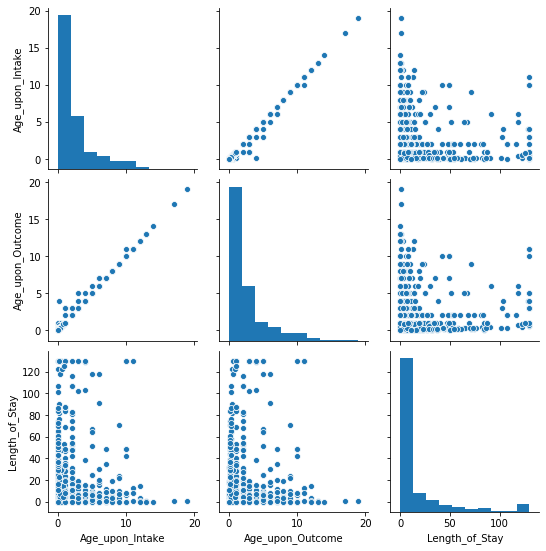

In [16]:
sns.pairplot(X_train, vars=['Age_upon_Intake', 'Age_upon_Outcome', 'Length_of_Stay'])

We can see from the correlation figures and scatterplots that:
- Age_Upon_Intake and Age_upon_Outcome are almost perfectly correlated, as expected. (the dots almost form a perfect straight line)
- There is no correlation between Length_of_Stay and either Age_upon_Intake or Age_upon_Outcome (the dots are not group in any obvious pattern).

The very close correlation of of the two ages features means we might be able to drop one of them without losing any information. It will be confirmed in the next section if they affect the target outcome in the same way and a decision can be taken at that point.

### Pairwise interactions between each continuous feature and the target outcome

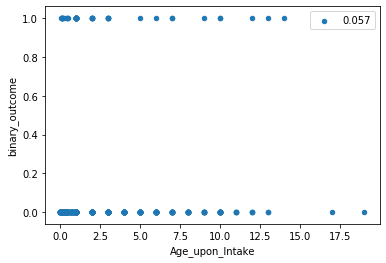

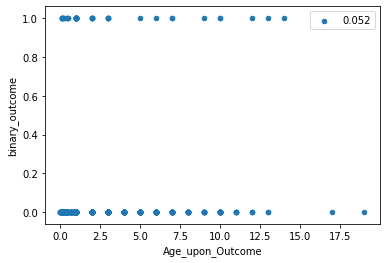

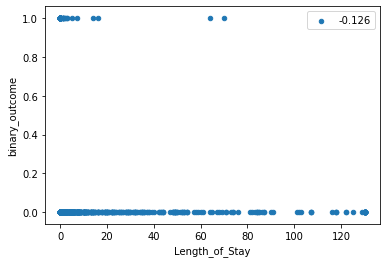

In [17]:
# plot pairwise interaction between all continuous features and target
continuous_features = ['Age_upon_Intake', 'Age_upon_Outcome', 'Length_of_Stay']

for column in continuous_features:
    # create temp df to merge column and target
    # target must be converted to numeric
    df_temp = pd.concat([X_train[column], y_train.astype('float64')], axis=1)
    # calculate correlation to display on plot
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # scatterplot for each feature and the target feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)

Observations:

 - **Age_upon_Intake and Age_upon_Outcome**

The plots and figures show that there is hardly any correlation between either age feature and our target outcome.

As both ages features are extremely closely correlated (with a Pearson'r correlation coefficient of 0.996414), we will not lose any information by dropping one of them. In addition, the goal of this project is to predict the likely outcome for an animal, so of the two features, it would make sense to drop the feature that is only measured at the time of the outcome. As well as this, Age_upon_Outcome has the lowest correlation coefficient of the two age features with regards to the target outcome.

It could be argued that Age_upon_Intake is worth keeping, even with a very low correlation coefficient with our target outcome as if we add up lots of features with small correlation coefficients, they may together add up and have a noticeable impact on the performance of our model. However, the exploration in Homework 1 found that the impact of this feature on the target outcome was mostly related to whether an animal was younger than 1 year, or 1 year and older. A soecific feture was created to capture this impact. As a result, I believe the information contained in the Age_upon_Intake feature is already captured by Younger_than_1_Intake, and in a more meaningful way. So Age_upon_Intake can be dropped.

- **Length_of_Stay**

There is a small negative correlation between this feature and our target outcome, meaning a longer stay at the shelter is only very loosely correlated to a positive outcome (outcome of 0). As we saw in Homework 1 though, there are a number of reasons that could explain this correlation. For example, a very short length of stay could mean that an animal arrived in very bad shape and was euthanised immediately. A wild animal would also not be likely to spend much time at the shelter but they are much more likely to meet a negative outcome. So the driver here is the wildness of the animal, not the length of the stay. The causality of this feature is unclear.

In terms of the distribution, there were also much fewer animals with a length of stay above 80 days, so this must be taken into account.

Because of the low correlation and the dubious causality, I will drop this feature for now.

### Pairwise interactions between each categorical feature and the target outcome

We have 11 categorical features:
- Named
- Found_Location
- Intake_Type
- Intake_Condition
- Animal_Type
- Sex_upon_Intake
- Breed
- Color
- Sex_upon_Outcome
- Wild
- Younger_than_1_Intake

Each feature's interaction with the target outcome will be visualised using a stacked bar plot

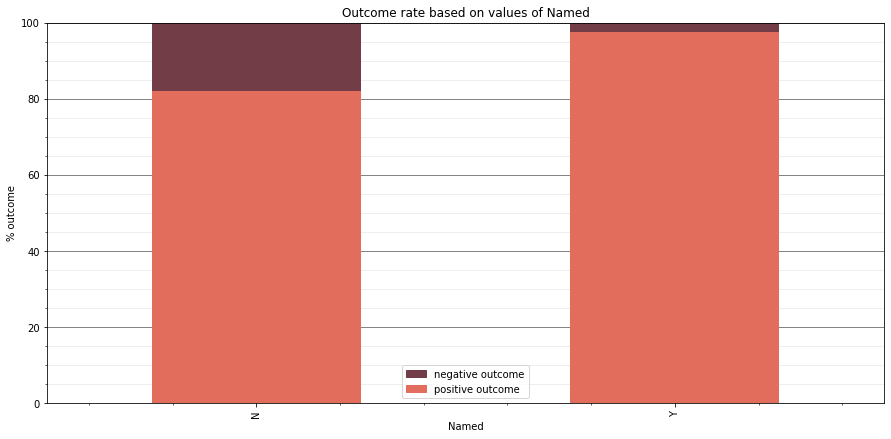

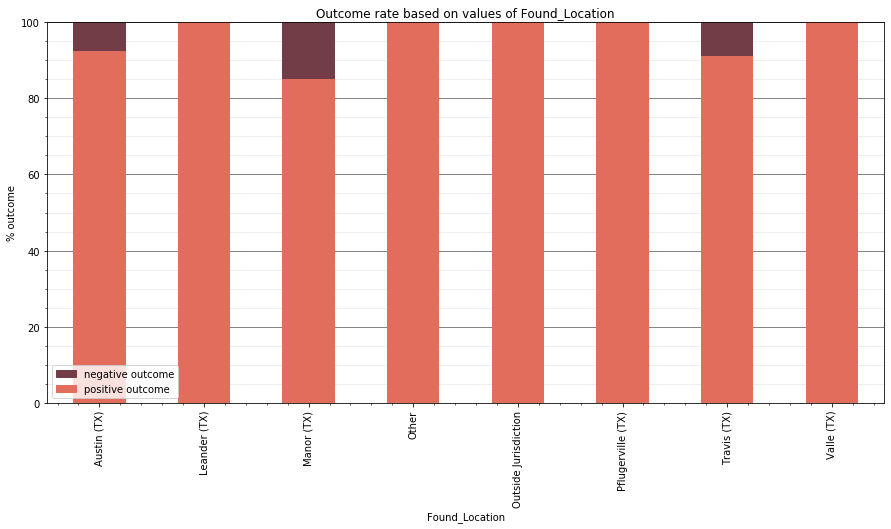

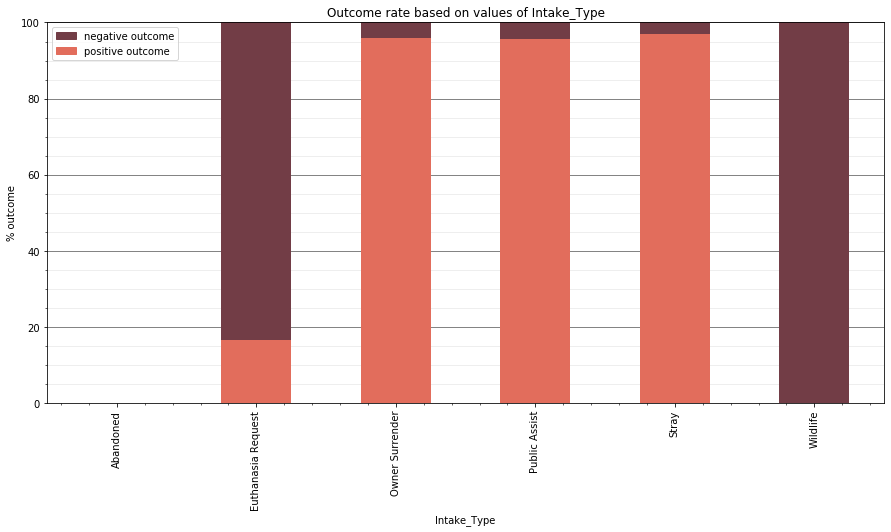

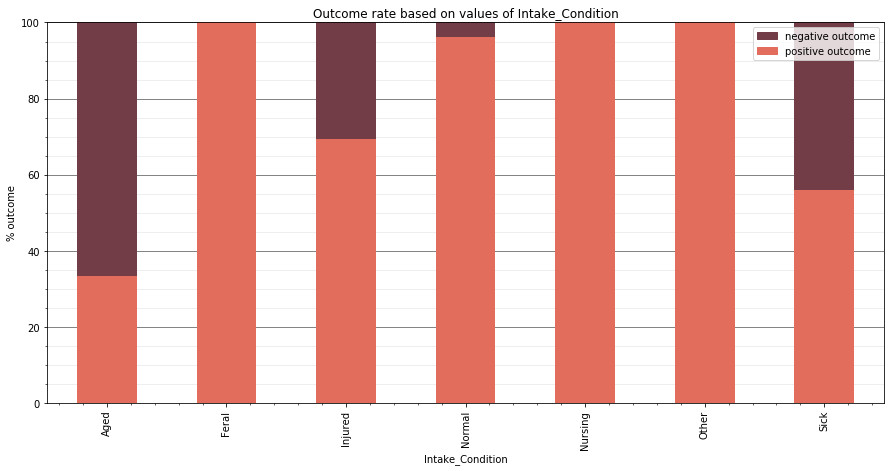

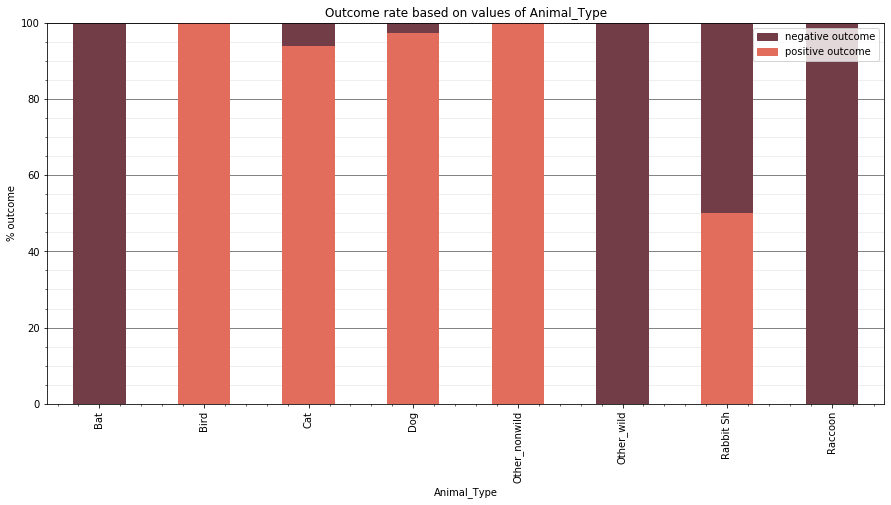

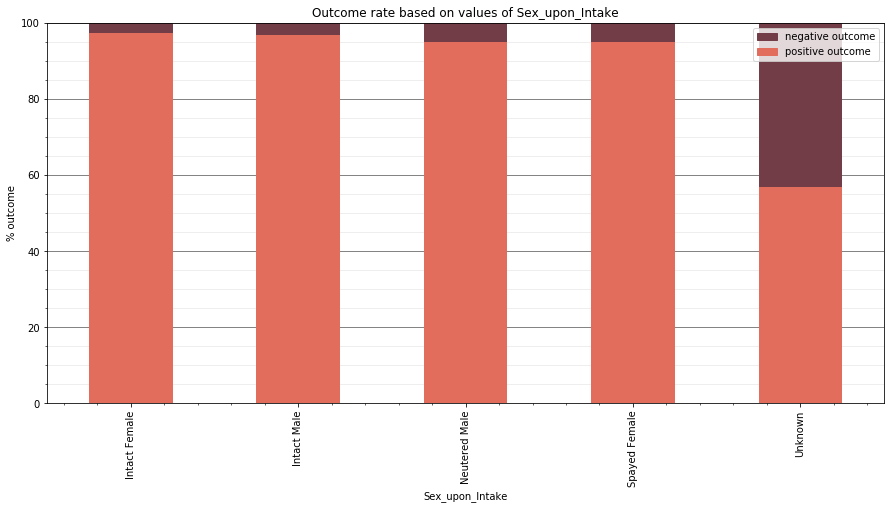

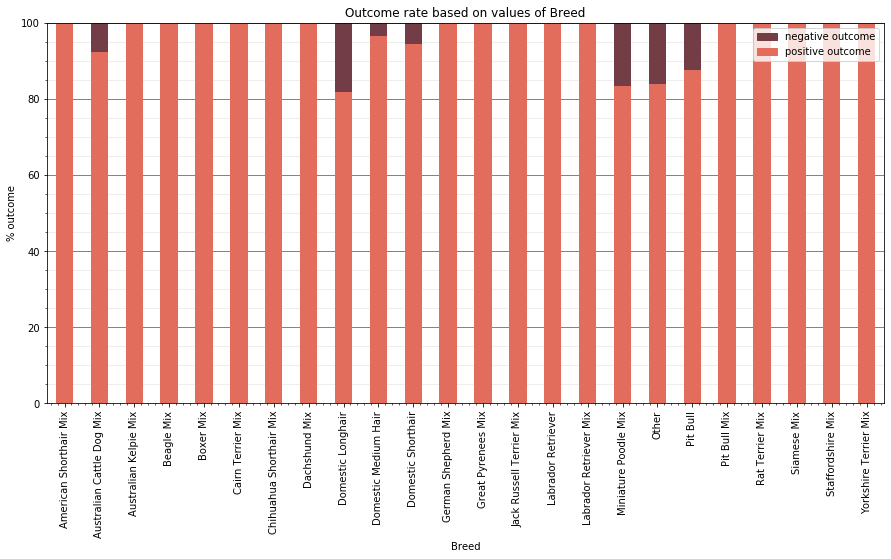

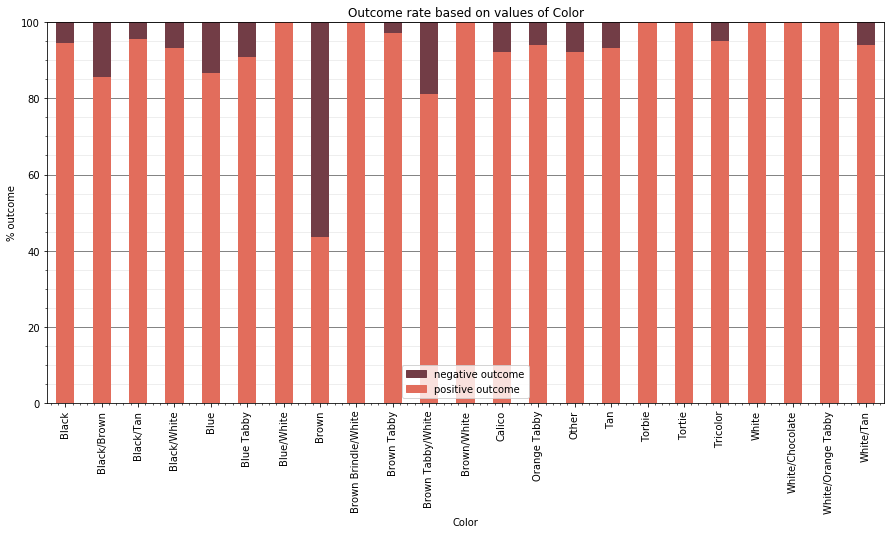

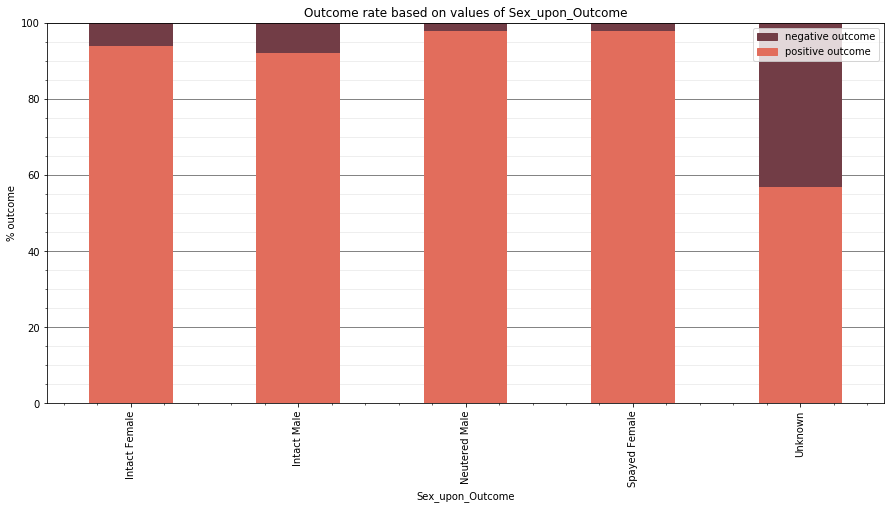

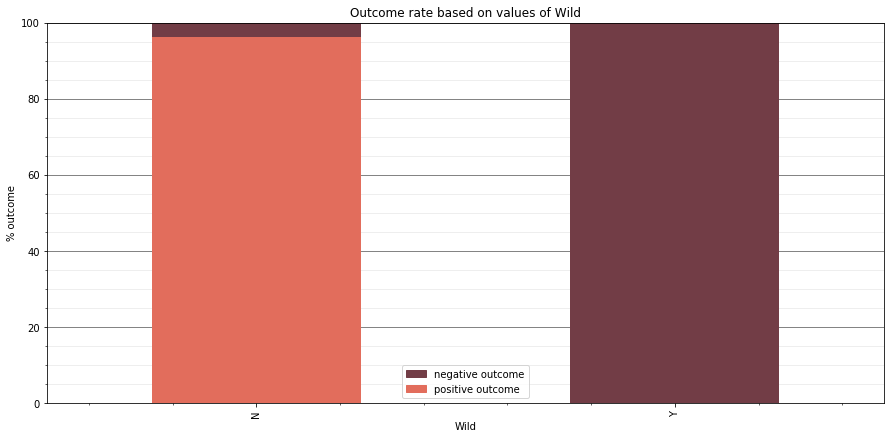

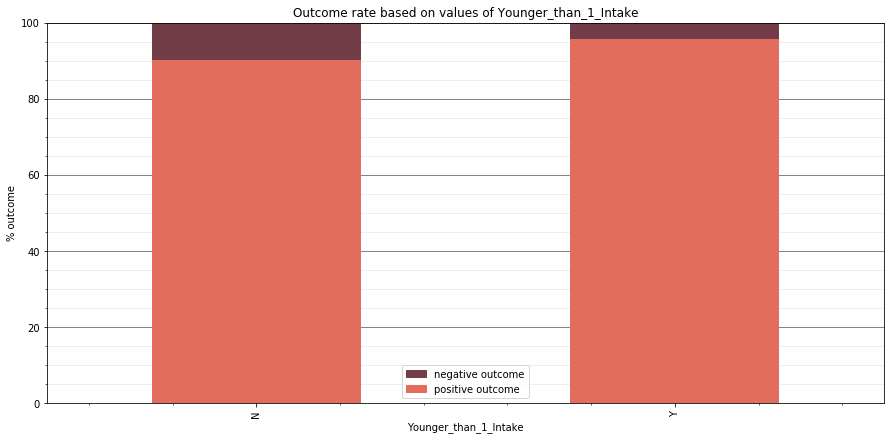

In [18]:
# first we need to merge x and y into one df for plotting
df_temp= pd.concat([X_train, y_train], axis=1)


# list categorical features
categorical_features = ['Named', 'Found_Location', 'Intake_Type', 'Intake_Condition', 'Animal_Type', \
                       'Sex_upon_Intake', 'Breed', 'Color', 'Sex_upon_Outcome', 'Wild',\
                       'Younger_than_1_Intake']

# Generate stacked plot for the target outcome with each categorical feature 
for feature in categorical_features:
    
    levels = pd.unique(df_temp[feature].ravel())

    df_temp['percent'] = 0

    for i in levels:
        count = 1 / df_temp[df_temp[feature] == i].count()['binary_outcome']
        index_list = df_temp[df_temp[feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count * 100
        
    group = df_temp[['percent',feature,'binary_outcome']].groupby([feature,'binary_outcome']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title="Outcome rate based on values of {}" \
                                   .format(feature), figsize=(15,7), color=["#E26D5C", "#723D46"])
    
    # legend
    neg_patch = mpatches.Patch(color="#723D46", label='negative outcome')
    pos_patch = mpatches.Patch(color="#E26D5C", label='positive outcome')
    my_plot.legend(handles=[neg_patch, pos_patch], frameon = True)
    
    # gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-', axis='y')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', axis='y', alpha=0.2)
    my_plot.set_axisbelow(True) # show gridlines behind the bars
    
    my_plot.set_xlabel(feature)
    my_plot.set_ylabel("% outcome")
    my_plot.set_ylim([0,100])

    plt.show()

#### Observations:

- **Named**

The value of this binary flag feature does appear to influence the target outcome, with unnamed animals 15% less likely to have a negative outcome. It could be argued that this is because **wild** animals don't get named at the shelter and are more likely to meet a negative outcome. But some other animal types also don't get named. So not all the meaning of this feature would be captured in the 'Wild' flag feature.

In [19]:
df[(df.Named == 'N') & (df.Wild == 'N')].Named.count()

308

As we can see, 308 unnamed animals (in the full original dataset) are not wild. So not all unnamed animals are covered by our 'Wild' binary flag.

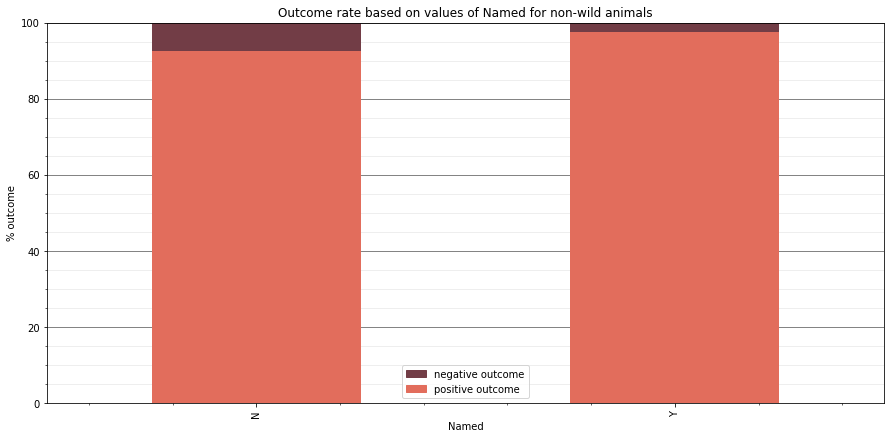

In [20]:
feature = 'Named'

df_temp2 = df_temp[df_temp.Wild == 'N']

levels = pd.unique(df_temp2[feature].ravel())

df_temp2['percent'] = 0

for i in levels:
    count = 1 / df_temp2[df_temp2[feature] == i].count()['binary_outcome']
    index_list = df_temp2[df_temp2[feature] == i].index.tolist()
    for ind in index_list:
        df_temp2.loc[ind, 'percent'] = count * 100
        
group = df_temp2[['percent',feature,'binary_outcome']].groupby([feature,'binary_outcome']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="Outcome rate based on values of {} for non-wild \
animals" .format(feature), figsize=(15,7), color=["#E26D5C", "#723D46"])
    
# legend
neg_patch = mpatches.Patch(color="#723D46", label='negative outcome')
pos_patch = mpatches.Patch(color="#E26D5C", label='positive outcome')
my_plot.legend(handles=[neg_patch, pos_patch], frameon = True)
    
    # gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-', axis='y')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', axis='y', alpha=0.2)
my_plot.set_axisbelow(True) # show gridlines behind the bars
    
my_plot.set_xlabel(feature)
my_plot.set_ylabel("% outcome")
my_plot.set_ylim([0,100])

plt.show()

As well as this, we can see above that even if we include only non-wild animals in our representation, there is still a difference in outcome of about 5% between named and unnamed animals.

- **Found_Location**

From the chart, we can see that different locations can have different rates of outcome. Depending on the location, there can be a variation of up to 15% in the type of outcome. As established in Homework 1, the disproportionate rate of negative outcomes from Manor (TX) is not due to more wild animals being found in Manor (TX) for example. So this information is not captured by any other feature and should be kept in our training set.

Also worth noting is that our training set does not include any cases from 3 locations (Ridge, Rock and Cave (TX)). From the analysis in Homework1, I can see that these are 3 values of Found_Location that appear only once in the dataset, so this should not cause any issues in terms of the modelling. It will also be captured when we train and evaluate using cross-validation in Part 2.

- **Intake_Type**

This feature is likely to be a very strong predictor of the target_outcome, with up to 97% difference in outcome between some of the values (e.g. Wildlife and Stray). Even if we exclude 'Wildlife' (which is already covered by the Wild flag feature), there is still up to 15% difference in outcome between values, because of the Euthanasia Request value. This value's impact on the target outcome must be capture in our model.

It's worth noting that our training set does not currently include a case with a value of 'Abandoned'. However, this value appears only once in the full dataset (see below), so it's unlikely to cause any issues with the modelling. It will also be captured when we train and evaluate using cross-validation in Part 2.

- **Intake_Condition**

This appears to be a good predictor of outcome, with up to 32% variation in outcome between different values.

- **Animal_Type**

This feature appears to be a very strong predictor of outcome with a variation of up to 100% between different values. It could be argued that this information is already contained in our 'Wild' flag feature, since the animals with very high rates of negative outcomes are wild animals. However, if we were to drop this feature, we would fail to capture the 3 or 4% difference in outcome for cats and dogs that is apparent on this bar chart.

We could potentially reduce the cardinality of this feature to more efficiently capture the difference in their predicitive effect (perhaps we could group some animal types together where they all have the same outcome i.e. where their individual types don't have any effect on outcome) but this may lead to overfitting in our model and may not adapt well to other datasets, where perhaps some specific wild animal types did have positive outcomes.  

- **Sex_upon_Intake**

The biggest difference in impact on the outcome here lies with the value of 'Unknown'. We could argue that a large part of this is already captured by the 'Wild' flag, but this does not cover everything as there are also some non-wild animals with a Sex_upon_Intake value of 'Unknown', some with positive outcomes and some with negative outcomes. (see below) 

There is a also difference of about 2% in the outcome between 'Intact' and 'Neutered/Spayed' vallues, with animals arriving already neutered or spayed ever so slightly more likely to have a negative outcome.

In [21]:
df_temp[(df_temp.Sex_upon_Intake == 'Unknown') & (df_temp.Wild == 'N') & \
        (df_temp.binary_outcome == 1.0)].Sex_upon_Intake.count()

4

In [22]:
df_temp[(df_temp.Sex_upon_Intake == 'Unknown') & (df_temp.Wild == 'N') & \
        (df_temp.binary_outcome == 0.0)].Sex_upon_Intake.count()

38

- **Sex_upon_Outcome**

The effect described above for Sex_upon_Intake between 'Intact' and 'Spayed/Neutered' is reversed for this feature, with a slightly higher impact (up to 5% difference between the two). However, I believe this may be a case of 'self fulfilling prophecy', in the sense that an animal that arrived 'Intact' but in bad shape and had a negative outcome, was less likely to have had time to get neutered at the shelter after arrival.

- **Breed**

The Breed feature appears to have a medium impact on the target outcome, with differences of up 18% in the outcome between values.

One thing to note is that the 'Other' value encompasses both pet breeds that weren't common in the dataset, as well as wild breeds (as a result of cardinality reduction measures implemented in Homework 1), so we may be losing some of the detail here. Hopefully, the distinction will be captured by the combination of this feature with Animal_Type and Wild flag as model parameters. But it's worth noting this feature might be a good candidate for fine tuning later in part 5.  

- **Color**

There does seem to be variation between different values of Color and the rate of positive/negative outcome. Even if we disregard the 'Brown' value (which has a much higher rate of negative outcome, given that bats are brown and all have negative outcomes), there is up to 20% difference in the outcome rate between different values. 

However, there is a possibility that these apparent correlations may only be due to chance. To assess this at this point would require further statistical analysis and is outside the scope of this exercise. However, the last step in Part 5 (testing the models on a brand new dataset) would highlight any issues if that turned out to be the case. So I believe this feature may be capturing useful information and is worth keeping.

- **Wild**

This feature is obviously a very strong predictor or our outcome, with 98% difference in the rate of outcome between a wild animal and a non-wild animal.

- **Younger_than_1_Intake**

There is about 6% difference in the rate of outcome between the two values. This is not a great predictor of our outcome.


### Comparing the categorical features in terms of their potential to predict the target outcome

The strongest predictor of the target outcome appears to be the **Wild** flag feature. So this needs to be kept in our training set.


There a number of other promising features, with over 20% difference in outcome between values, which should also be kept:

- **Sex_upon_Intake** (up to 40% difference in outcome rates for different values, though wild status accounts for a lot of that)
- **Intake_Condition** (up to 32% difference in outcome rate for different values)
- **Color** (20% difference even if we disregard the *Brown* value that includes bats)


The following are slightly less promising but can add up and when combined could be found to have a noticeable impact on model performance, so they will be kept:

- **Found_Location** (up to 15% difference in outcome rate for different values)
- **Intake_Type** (up to 15% difference if we exclude Wildlife, up to 97% when including Wildlife)
- **Breed** (up to 18% difference)


More questionable features:

- **Animal_Type** - if we exclude wild animals (already captured by the Wild flag), this only leaves a maximum 3% difference in outcome for different Animal_Types, which doesn't seem promising. However, it captures the small difference in outcome between cats and dogs, and as these are the most frequent animal types in our dataset, I believe it is important to capture this detail. So **this feature will be kept**.


- **Sex_upon_Outcome** - The difference in outcome when considering only non-wild animals is minimal here. **this feature will be dropped**.


- **Named** - There is only a 5% difference in outcome between the two values if we exclude wild animals. Wild animals are all unnamed, and covered by the Wild flag feature. **This feature will be dropped** for now but it could be a feature to include in Part 5 to see if it can help refine the model.


- **Younger_than_1_Intake** - There is only a 6% difference in outcome between the two values for this feature, so it's no very promising. As well as this, the meaning of the age of an animal depends on the type of animal it is. e.g. being just under 1 year old is quite young for a cat or dog, but not that young if you consider a mouse. However, I have already dropped the continuous age features, so I am reticent to drop this feature as it would risk losing some information, even if it's minimal.**This feature will be kept** for now, and this can revisited in part 5.

### Dealing with the date features (DateTime_Intake and DateTime_Outcome)

The data exploration in Homework 1 did not find any seasonal pattern in the target outcome. So I will exclude these features for now. 

They could potentially be transformed into several categorical features (e.g. day of the week) at a later stage, to see if that can improve the accuracy of our models.

### Preparing the dataset for modelling

A number of steps are now required to prepare the dataset for modelling:
- create a copy of the df to use as the basis
- drop the low information features as determined in the analysis above
- one hot encode the categorical features and drop the reference level
- split the dataset into train/test datasets

In [23]:
# Create a copy of the dataframe to use as the basis for modelling
dfm = df.copy()

In [24]:
# Drop the low information features
dfm.drop(['Age_upon_Intake', 'Age_upon_Outcome', 'Length_of_Stay','Sex_upon_Outcome', 'Named', 'DateTime_Intake',\
          'DateTime_Outcome'], axis=1, inplace=True)

In [25]:
dfm.dtypes

Found_Location             object
Intake_Type              category
Intake_Condition         category
Animal_Type                object
Sex_upon_Intake          category
Breed                    category
Color                    category
binary_outcome           category
Wild                     category
Younger_than_1_Intake    category
dtype: object

The target feature's data type must be changed to a numeric feature prior to modelling

In [26]:
dfm["binary_outcome"] = pd.to_numeric(dfm["binary_outcome"])

In [27]:
dfm.dtypes

Found_Location             object
Intake_Type              category
Intake_Condition         category
Animal_Type                object
Sex_upon_Intake          category
Breed                    category
Color                    category
binary_outcome            float64
Wild                     category
Younger_than_1_Intake    category
dtype: object

In [28]:
# One-hot encoding of categorical features
dfm = pd.get_dummies(dfm)

In [29]:
dfm.columns

Index(['binary_outcome', 'Found_Location_Austin (TX)',
       'Found_Location_Leander (TX)', 'Found_Location_Manor (TX)',
       'Found_Location_Other', 'Found_Location_Outside Jurisdiction',
       'Found_Location_Pflugerville (TX)', 'Found_Location_Travis (TX)',
       'Found_Location_Valle (TX)', 'Intake_Type_Abandoned',
       'Intake_Type_Euthanasia Request', 'Intake_Type_Owner Surrender',
       'Intake_Type_Public Assist', 'Intake_Type_Stray',
       'Intake_Type_Wildlife', 'Intake_Condition_Aged',
       'Intake_Condition_Feral', 'Intake_Condition_Injured',
       'Intake_Condition_Normal', 'Intake_Condition_Nursing',
       'Intake_Condition_Other', 'Intake_Condition_Sick', 'Animal_Type_Bat',
       'Animal_Type_Bird', 'Animal_Type_Cat', 'Animal_Type_Dog',
       'Animal_Type_Other_nonwild', 'Animal_Type_Other_wild',
       'Animal_Type_Rabbit Sh', 'Animal_Type_Raccoon',
       'Sex_upon_Intake_Intact Female', 'Sex_upon_Intake_Intact Male',
       'Sex_upon_Intake_Neutered Mal

In [30]:
# Drop the reference level for each of the one-hot encoded features
dfm.drop(['Found_Location_Austin (TX)', 'Intake_Type_Owner Surrender', 'Intake_Condition_Aged', 'Animal_Type_Bat',\
         'Sex_upon_Intake_Intact Female','Breed_American Shorthair Mix','Color_Black', 'Wild_N', \
          'Younger_than_1_Intake_N'], axis=1, inplace=True)

In [31]:
# Split into train/test datasets

# y is the target
y = dfm["binary_outcome"]
# X is everything else
X = dfm.drop(["binary_outcome"], axis=1)

# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",dfm.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000


In [32]:
# Reset all indexes
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Found_Location_Leander (TX),Found_Location_Manor (TX),Found_Location_Other,Found_Location_Outside Jurisdiction,Found_Location_Pflugerville (TX),Found_Location_Travis (TX),Found_Location_Valle (TX),Intake_Type_Abandoned,Intake_Type_Euthanasia Request,Intake_Type_Public Assist,...,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_White/Chocolate,Color_White/Orange Tabby,Color_White/Tan,Wild_Y,Younger_than_1_Intake_Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The dataset have been split into train and test datasets which are now ready for modelling.

# Part 2 - Predictive Modelling: Linear Regression

### 2.1. Train linear regression model on training set to predict target feature

In [33]:
# Train a model using all features
multiple_linreg = LinearRegression().fit(X_train, y_train)

In [34]:
multiple_linreg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 2.2. Print and discuss coefficients learned by the model

#### Intercept

In [35]:
# Print the intercept learned

pd.set_option('float_format', '{:f}'.format) # remove automatic scientific notation
print("\nIntercept is: \n", multiple_linreg.intercept_)


Intercept is: 
 0.21494648359563456


In a linear regression model, the intercept can be interpreted as the value of the target outcome when all input features have a value of 0. As we are dealing with only categorical features here, and the prediction is a classification problem, the intercept doesn't really carry meaning in a numerical sense.


We could say that when all the features in the model have a value of 0, this means that all the reference levels have a value of 1. So in our case here, an aged non-wild intact female black bat surrendered by their owner in Austin with a breed of American Shorthair Mix and over 1 year old would lead to a predicted value of the intercept, i.e. a predicted value of 0.21. Which after thresholding, would predict a class of 0 (a positive outcome). However, this mix of feature values is obviously nonsensical, as bats are wild and American Shorthair Mix is a breed of cats. So this combination of feature values would never happen in a dataset. Therefore, while it does play an important role in the calculations, the intercept is not really interpretable for our model.

#### Coefficients

In [36]:
# Put coefficients learned for each feature into a dataframe for ease of inspection
pd.options.display.max_columns = 120 # remove default ellipsing of columns
d = dict(list(zip(X_train.columns, multiple_linreg.coef_)))
df_coef = pd.DataFrame(data=d, index=[0])
df_coef

,Found_Location_Leander (TX),Found_Location_Manor (TX),Found_Location_Other,Found_Location_Outside Jurisdiction,Found_Location_Pflugerville (TX),Found_Location_Travis (TX),Found_Location_Valle (TX),Intake_Type_Abandoned,Intake_Type_Euthanasia Request,Intake_Type_Public Assist,Intake_Type_Stray,Intake_Type_Wildlife,Intake_Condition_Feral,Intake_Condition_Injured,Intake_Condition_Normal,Intake_Condition_Nursing,Intake_Condition_Other,Intake_Condition_Sick,Animal_Type_Bird,Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other_nonwild,Animal_Type_Other_wild,Animal_Type_Rabbit Sh,Animal_Type_Raccoon,Sex_upon_Intake_Intact Male,Sex_upon_Intake_Neutered Male,Sex_upon_Intake_Spayed Female,Sex_upon_Intake_Unknown,Breed_Australian Cattle Dog Mix,Breed_Australian Kelpie Mix,Breed_Beagle Mix,Breed_Boxer Mix,Breed_Cairn Terrier Mix,Breed_Chihuahua Shorthair Mix,Breed_Dachshund Mix,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd Mix,Breed_Great Pyrenees Mix,Breed_Jack Russell Terrier Mix,Breed_Labrador Retriever,Breed_Labrador Retriever Mix,Breed_Miniature Poodle Mix,Breed_Other,Breed_Pit Bull,Breed_Pit Bull Mix,Breed_Rat Terrier Mix,Breed_Siamese Mix,Breed_Staffordshire Mix,Breed_Yorkshire Terrier Mix,Color_Black/Brown,Color_Black/Tan,Color_Black/White,Color_Blue,Color_Blue Tabby,Color_Blue/White,Color_Brown,Color_Brown Brindle/White,Color_Brown Tabby,Color_Brown Tabby/White,Color_Brown/White,Color_Calico,Color_Orange Tabby,Color_Other,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_White/Chocolate,Color_White/Orange Tabby,Color_White/Tan,Wild_Y,Younger_than_1_Intake_Y
0,-0.006806,0.106020,-0.003643,-0.063604,-0.069076,-0.031854,-0.044898,577178843600.117920,0.582134,-0.015015,-0.017342,-0.083008,-0.283152,-0.095581,-0.281036,-0.317467,-0.317780,-0.117077,-0.155449,0.029416,-0.068375,-0.123692,-0.112264,-0.164736,-0.105183,-0.002617,0.003159,0.000381,0.080780,0.176819,0.121239,0.157756,0.142090,0.110985,0.111073,0.131395,0.185610,0.039680,0.065945,0.119581,0.162491,0.132481,0.138069,0.112202,0.157808,0.168396,0.219414,0.145721,0.179001,0.048532,0.126537,0.129173,0.067465,0.048814,0.006439,0.078552,0.069467,-0.022565,0.015606,0.005875,-0.025208,0.114849,-0.009155,0.013973,0.031517,0.002869,0.061410,-0.029884,-0.023521,0.016080,-0.012833,0.008921,-0.032974,0.043770,0.863701,-0.007355


The coefficient assigned to each feature indicates the relative predictive strength of the feature. A higher absolute value means a stronger impact on the target outcome.

While there are too many features in our dataset to discuss each one individually, we can still make the following observations:

- The highest absolute coefficient was assigned to the **Wild_Y** feature, meaning that this feature has the highest impact on the target outcome. This is in line with prior findings during the exploratory phase of the data analysis.


- The second highest coefficient is **Intake_Type_Euthanasia_Request**, which is also as expected as it was found to have a high proportion of negative outcomes.


- There is an anomaly with **Intake_Type_Abandoned** having an extremely large coefficient of 577,178,843,600. This is due to the fact there is no record in our training set with a value of "Abandoned" for feature Intake_Type. There is only one record in the full dataset with that value and it was randomly assigned to the test dataset. Unfortunately, it could not be binned with other values into an "Other" bin, as other values carried meaning for the target outcome and there were no other rare values to bin together with it. This will inevitably lead to a false positive when we apply the model to the test dataset, as it will result in a very high predicted value well above our classification threshold of 0.5, thus resulting in a predicted binary outcome of 1 when the actual outcome for this animal was 0. Though it will only affect one record, and is unlikely to affect the accuracy of our model for the current dataset, we will need to address it later as it would affect the accuracy of the model on a new dataset containing more records with "Abandoned" as Intake Type. This can be addressed in Part 5.


- **Intake Conditions** in general have higher coefficients than most other features and so appear to have good predictive strength, with the exception of Intake_Condition_Injured and Intake_Condition_Sick which are slightly weaker predictors. 


- Most features related to **Found Location** have relatively low coefficients, with the exception of **Found_Location_Manor**. This is also in line with our findings during the exploratory phase, when we found that Manor (TX) had an unusually high proportion of negative outcomes.


- An interesting point is that neither **Color_Brown** nor **Intake_Type_Wildlife** have high coefficients, even though they were previously found to be indicators of a negative outcome (100% negative outcomes for an Intake_Type value of *Wildlife*). This may be because the Wild_flag feature has a very high coefficient, so maybe the predictive strength of these features is already accounted for in the Wild_flag. There may be collinearity issues here between those features, which can be investigated in Part 5.


- **Younger_than_1_Intake_Y** has a very low absolute value and this confirms that it is a very weak predictor of target outcome.

### 2.3. Print predicted target feature for the first 10 examples in the training set and evaluate model performance on full training set

The output of the linear regression model is not a probability. As we are dealing with a classification problem, we need to convert the output into a binary classification using an additional thresholding step.

A threshold value of 0.5 will be applied to the output: any values >= 0.5 will be cast to 1, and any values <0.5 will be cast to 0.

In [37]:
# calculate the prediction and threshold the value
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0        1.000000          1
1        0.000000          0
2        1.000000          1
3        0.000000          0
4        0.000000          0
5        0.000000          0
6        0.000000          0
7        0.000000          0
8        0.000000          0
9        0.000000          0


In [38]:
# Evaluation metrics
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9685714285714285
Confusion matrix: 
 [[647   1]
 [ 21  31]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       648
         1.0       0.97      0.60      0.74        52

    accuracy                           0.97       700
   macro avg       0.97      0.80      0.86       700
weighted avg       0.97      0.97      0.97       700



#### Accuracy

This means the model is predicting the correct class 96.86% of the time. However, our dataset is imbalanced and contains a much higher proportion of examples in the negative class than in the positive class. As a result, the accuracy rate alone is not very meaningful and we need to compare this value to the percentage of the majority class.

Since the majority class here is 92.57% of the training dataset, the accuracy of this linear regression model is better than a model simply predicting the majority class all of the time.

#### Confusion matrix

The confusion matrix indicates:
- 647 true negatives i.e. in 647 cases, the model predicted an outcome of 0 correctly
- 1 false positive i.e. in 1 case, the model predicted an outcome of 1 where actual outcome was 0
- 21 false negatives i.e. in 21 cases, the model predicted an outcome of 0 where actual outcome was 1
- 31 true positives i.e. in 31 cases, the model correctly predicted an outcome of 1.

#### Precision

The ratio of correctly predicted positives over the total predicted positives i.e. the percentage of positives predicted that were actually positive. **The precision rate of the model is 97%**.

#### Recall

The recall of the positive class (True Positive Rate) indicates the sensitivity of our model i.e. how good the model is at predicting positive values. The rate here is 60% which is quite low. This means the model is only detecting 60% of the positive class examples.

The recall of the negative class (True Negative Rate) indicates the specificity of the model i.e. how good the model is at predicting negative values. The rate here is 100% (this figure must have been rounded, as we can see that the model predicted 647 out of the 648 negatives).

#### F1 Score

The F1 score is an aggregation of precision and recall and is another measure of accuracy. It can be seen as the trade-off between Precision and Recall. F1 score positive is 0.74 and F1 score negative is 0.98.


#### Summary of evaluation

- The model has a high rate of accuracy, but only 4.3% better than a model predicting the majority class all of the time.


- The model has a very high (near perfect) specificity but low sensitivity. This means it is very good at predicting the negative class (positive outcome for the animal) but quite bad at predicting the positive class (negative outcome for the animal). There is a large majority class of positive outcomes (negative class) so this might explain the model's performance.


- The low sensitivity is not ideal because the objective of our project is to predict negative outcomes for the animals. We are looking to identify the factors that impact a negative outcome the most in order to make recommendations. To achieve this goal, we would need higher sensitivity. There is often a trade-off between specificity and sensitivity in machine learning models, and when comparing different models to select the best one, we will need to look at the combination of both, and which is combined performance is best for our particular problem. For example, missing some positive outcomes (i.e. negative cases) could also be a problem, as we wouldn't want the shelter to turn away animals that could have had a positive outcome if they had been taken in.

### 2.4. Evaluate the model on the hold-out test set

We will now test the model trained on the training dataset by using our hold-out test dataset as inout and compare the results.

In [39]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0        0.000000   0.000000
1        0.000000   0.000000
2        0.000000   0.000000
3        0.000000   0.000000
4        0.000000   0.000000
5        0.000000   0.000000
6        0.000000   0.000000
7        0.000000   0.000000
8        0.000000   0.000000
9        0.000000   0.000000


In [40]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9566666666666667
Confusion matrix: 
 [[278   1]
 [ 12   9]]
Classification report - Test data:
                precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       279
         1.0       0.90      0.43      0.58        21

    accuracy                           0.96       300
   macro avg       0.93      0.71      0.78       300
weighted avg       0.95      0.96      0.95       300


==================== Train Data ======================
Accuracy:  0.9685714285714285
Confusion matrix: 
 [[647   1]
 [ 21  31]]

Classification report: - Training data
                precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       648
         1.0       0.97      0.60      0.74        52

    accuracy                           0.97       700
   macro avg       0.97      0.80      0.86       700
weighted avg       0.97      0.97      0.97       700



#### Comparison of results

- Accuracy:
    - The accuracy of the model on the test data has reduced by 1.2% to 95.67%. This is still higher than a simple majority class prediction.
    
- Precision:
    - The precision score has reduced by 7% to 90%.
    
- Recall:
    - True Positive Rate: the sensitivity has reduced by 17% to 43%
    - True Negative Rate: the specificity has not changed and is still at 100% (rounded)
    
- F1 Score:
    - The F1 score for predicting the positive cases has reduced by 16% from 74% to 58%
    - The F1 score for predicting the negative cases has not changed at 98%
    
**Summary**

- While the overall accuracy has not reduced by very much, the model's ability to predict positive cases has reduced quite a lot. The model does not generalise well for identifying positive cases. 

### 2.5. Train and evaluate using cross-validation

First, we will train models on the full dataset using 10-fold cross-validation. We will then take an average of the metrics obtained and compare with the results from our previous model trained with a single train/test split.

In [41]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy', threshold=0.5):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The random state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= threshold) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

In [42]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

In [43]:
linRegDF = cross_val_LinReg_DF(X,y)
print("Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.963333
precision,0.915490
recall,0.525112
f1,0.660277


#### Summary of findings

- Accuracy:
    - The average accuracy rate is 96.33, which is higher than the model learned using only the training dataset when evaluated on the hold-out test set (95.67%)

- Precision:
    - The average precision rate of the models trained using cross-validation is 91.55%, which is only slightly higher than the model learned using only the training dataset when evaluated on the hold-out test set (90%)
    
- Recall (true positive rate):
    - The recall is 52.51%, which is much higher than than the recall of the model learned on the training set when evaluating on the hold-out test set (43%)
    
- F1 Score:
    - The f1 score is 66%, higher than that of the model learned on the training set when evaluating on the hold-out test set  (58%)

Overall, these results are a bit more encouraging that the metrics obtained with the model learned on the training set (evaluated on the hold-out test set).
    
NB: Here we are comparing the average performance of 10 models with the performance of one model learned using train/test split. The metrics obtained with cross-validation will be more useful for comparing the suitability of different types of models: Linear Regression vs. Logistic Regression vs. Random Forest.

# Part 3 - Predictive Modelling: Logistic Regression

### 3.1. Train logistic regression model on training set to predict target feature

In [44]:
# Train a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

### 3.2. Print and interpret the coefficients learned by the model

The model estimated in logistic regression is given by the logistic function: <br>

$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>

In the same way as linear regression, logistic regression assumes a linear relationship between the features and the target outcome. However, the logistic function outputs a value between 0 and 1 that represents the probability of the target feature having a value of 1. The model will then apply a threshold (default 0.5) to this probability and make a class prediction based on whether the probability is higher or lower than the threshold.

#### Intercept

In [45]:
print("\nIntercept is: \n", multiple_logisticreg.intercept_[0])


Intercept is: 
 -1.4532556388248676


To interpret the intercept, we first need to apply the logistic function to it. This will output value between 0 and 1 that can be interpreted as the probability of the target feature having a value of 1.


$logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

So $logistic(intercept) = \frac{1}{1+e^{-intercept}} = \frac{1}{1+e^{1.4533}} = 0.1895$

When all the features have a value of 0 (i.e. when all the reference levels have a value of 1), the probability of the positive class (negative outcome) is 18.95%. However, in our particular case having a combination of all reference levels with a value of 1 is nonsensical and this will never apply (as seen in part 2).

#### Coefficients

In [46]:
# Put coefficients learned for each feature into a dataframe for ease of inspection

d = dict(list(zip(X_train.columns, multiple_logisticreg.coef_[0])))
df_coef = pd.DataFrame(data=d, index=[0])
df_coef

,Found_Location_Leander (TX),Found_Location_Manor (TX),Found_Location_Other,Found_Location_Outside Jurisdiction,Found_Location_Pflugerville (TX),Found_Location_Travis (TX),Found_Location_Valle (TX),Intake_Type_Abandoned,Intake_Type_Euthanasia Request,Intake_Type_Public Assist,Intake_Type_Stray,Intake_Type_Wildlife,Intake_Condition_Feral,Intake_Condition_Injured,Intake_Condition_Normal,Intake_Condition_Nursing,Intake_Condition_Other,Intake_Condition_Sick,Animal_Type_Bird,Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other_nonwild,Animal_Type_Other_wild,Animal_Type_Rabbit Sh,Animal_Type_Raccoon,Sex_upon_Intake_Intact Male,Sex_upon_Intake_Neutered Male,Sex_upon_Intake_Spayed Female,Sex_upon_Intake_Unknown,Breed_Australian Cattle Dog Mix,Breed_Australian Kelpie Mix,Breed_Beagle Mix,Breed_Boxer Mix,Breed_Cairn Terrier Mix,Breed_Chihuahua Shorthair Mix,Breed_Dachshund Mix,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd Mix,Breed_Great Pyrenees Mix,Breed_Jack Russell Terrier Mix,Breed_Labrador Retriever,Breed_Labrador Retriever Mix,Breed_Miniature Poodle Mix,Breed_Other,Breed_Pit Bull,Breed_Pit Bull Mix,Breed_Rat Terrier Mix,Breed_Siamese Mix,Breed_Staffordshire Mix,Breed_Yorkshire Terrier Mix,Color_Black/Brown,Color_Black/Tan,Color_Black/White,Color_Blue,Color_Blue Tabby,Color_Blue/White,Color_Brown,Color_Brown Brindle/White,Color_Brown Tabby,Color_Brown Tabby/White,Color_Brown/White,Color_Calico,Color_Orange Tabby,Color_Other,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_White/Chocolate,Color_White/Orange Tabby,Color_White/Tan,Wild_Y,Younger_than_1_Intake_Y
0,-0.079377,0.900912,-0.071283,-0.399546,-0.337832,-0.233641,-0.192838,0.000000,1.263514,-0.273109,-0.865183,1.229706,-0.065410,0.749998,-1.735490,-0.710158,-0.210618,0.960320,-0.324218,0.170414,-0.832065,-0.547633,0.062235,-0.097645,0.160496,-0.093570,-0.000492,-0.123466,1.310570,0.387871,-0.074075,-0.017705,-0.047038,-0.053906,-0.600754,-0.028151,0.707170,-0.358049,-0.035544,-0.172200,-0.017351,-0.042533,-0.058120,-0.521660,0.389329,1.125061,0.281676,-0.373390,-0.020552,-0.080271,-0.107434,-0.057365,0.524355,0.218746,-0.129764,0.340484,0.416543,-0.342704,0.695306,-0.163849,-0.383555,0.881848,-0.668223,-0.070608,0.129218,-0.200831,0.366322,-0.201115,-0.384530,0.088755,-0.505402,-0.090113,-0.244375,0.474815,1.636633,-0.317173


In logistic regression, each coefficient represents the change in the log-odds for a unit change in the corresponding feature. In the case of categorical variables as we have here, this means a value of 1 for the encoded feature results in a change in the log-odds of the value of the coefficient.

The change in odds for a feature value of 1 is given by the exponential of the coefficient. So a small change in the coefficient can lead to a big change in the odds.

A positive coefficient for a feature level means that this feature level is more likely to lead to a target outcome of 1 than the reference level. A negative coefficient means that this feature level is less likely to lead to a target outcome of 1 than the reference level. The absolute value of the coefficient indicates the magnitude of the effect of the feature value on the target outcome compared to the reference value.

We could calculate the probability change for each feature value from each coefficient using exponential and logistic functions in order to interpret the effect of each of the feature values. Given the number of encoded values, this is not feasible. However, we can make a number of observations.

**Observations**:

- There is no anomaly for **Intake_Type-Abandoned** in the logistic regression model (unlike in the previous linear regression model). The coefficient is 0, which seems appropriate as this value was not present in the dataset and thus the model is not able to determine the impact of this feature value. The logistic regression model seems better able to deal with feature values not appearing in the training set. It will be interesting to see if this affects the number of false positives (compared to the linear regression model).


- The highest coefficient is that of the **Wild_Y** feature value (1.64), which is as expected, since we found in our analysis that this is the strongest predictor of outcome. 


- **Sex_upon_Intake_Unknown** (1.31), **Intake_Type_Euthanasia Request** (1.26) and **Intake_Type_Wildlife** (1.23) have the highest positive coefficients after Wild flag. This is expected as they were found to tend to lead to negative outcomes (positive class) during our exploratory analysis.


- All the found locations are less likely to lead to a negative outcome (positive class) than Austin (TX) (the reference value) with the exception of Manor (TX).


- The **Color_Brown** feature value seems to be given more weight in this model than in the linear regression model (comparatively to other features in each model, as they cannot be compared to each other directly of course). Perhaps the logistic regression model handles collinearity differently.


- The **Younger_than_1_Intake_Y** has a negative coefficient of -0.31, meaning that it is less likely to lead to a positive class than the reference value **Younger_than_1_Intake_N**. This does not agree with our prior findings during the exploratory analysis, which showed that animals younger than 1 were slightly more likely to have a negative outcome. This may impact the accuracy of our model, or perhaps it is correct when used in combination with other feature weights. It is something to be explored/tested in Part 5.

### 3.3. Print the first 10 predictions on the training set and evaluate the model

In [47]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple logistic regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train,\
                                                                           columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple logistic regression: 

   binary_outcome  Predicted
0        1.000000   1.000000
1        0.000000   0.000000
2        1.000000   1.000000
3        0.000000   0.000000
4        0.000000   0.000000
5        0.000000   0.000000
6        0.000000   0.000000
7        0.000000   0.000000
8        0.000000   0.000000
9        0.000000   0.000000


In [48]:
# Evaluation metrics
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.97
Confusion matrix: 
 [[647   1]
 [ 20  32]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       648
         1.0       0.97      0.62      0.75        52

    accuracy                           0.97       700
   macro avg       0.97      0.81      0.87       700
weighted avg       0.97      0.97      0.97       700



#### Accuracy

The model is predicting the correct class 97% of the time. Since the majority class here is 92.57% of the training dataset, this accuracy is better than a model simply predicting the majority class all of the time.

#### Confusion matrix

The confusion matrix indicates:
- 647 true negatives i.e. in 647 cases, the model predicted an outcome of 0 correctly
- 1 false positive i.e. in 1 case, the model predicted an outcome of 1 where actual outcome was 0
- 20 false negatives i.e. in 20 cases, the model predicted an outcome of 0 where actual outcome was 1
- 32 true positives i.e. in 32 cases, the model correctly predicted an outcome of 1.

#### Precision

The ratio of correctly predicted positives over the total predicted positives i.e. the percentage of positives predicted that were actually positive. **The precision rate of the model is 97%**.

#### Recall

The recall of the positive class (True Positive Rate) indicates the sensitivity of our model i.e. how good the model is at predicting positive values. The rate here is 62% which is quite low. 

The recall of the negative class (True Negative Rate) indicates the specificity of the model i.e. how good the model is at predicting negative values. The rate here is 100% (this figure must have been rounded, as we can see that the model predicted 647 out of the 648 negatives).

#### F1 Score

The F1 score is an aggregation of precision and recall. F1 score positive is 0.75 and F1 score negative is 0.98


#### Summary of evaluation

- The model has a high rate of accuracy, 4.3% better than a model predicting the majority class all of the time, and similar to the accuracy of the linear regression model.


- Like the linear regression model, this model has a very high (near perfect) specificity but low sensitivity. Although the True Positive Rate is 2% higher, it is still quite low at 62%, meaning it is not great at identifying the positive class.

### 3.4. Evaluate the model on the hold-out test set

In [49]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0        0.000000   1.000000
1        0.000000   0.000000
2        0.000000   0.000000
3        0.000000   0.000000
4        0.000000   0.000000
5        0.000000   0.000000
6        0.000000   0.000000
7        0.000000   0.000000
8        0.000000   0.000000
9        0.000000   0.000000


In [50]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9533333333333334
Confusion matrix: 
 [[278   1]
 [ 13   8]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       279
         1.0       0.89      0.38      0.53        21

    accuracy                           0.95       300
   macro avg       0.92      0.69      0.75       300
weighted avg       0.95      0.95      0.94       300

==================== Train Data =======================
Accuracy:  0.97
Confusion matrix: 
 [[647   1]
 [ 20  32]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       648
         1.0       0.97      0.62      0.75        52

    accuracy                           0.97       700
   macro avg       0.97      0.81      0.87       700
weighted avg       0.97      0.97      0.97       700



#### Comparison of results

- Accuracy:
    - The accuracy of the model on the test data has reduced by 2% to 95.33%. This is still slightly higher than a simple majority class prediction.
    
- Precision:
    - The precision score has reduced by 8% to 89%.
    
- Recall:
    - True Positive Rate: the sensitivity has reduced by 24% to 38%
    - True Negative Rate: the specificity has not changed and is still at 100% (rounded)
    
- F1 Score:
    - The F1 score for predicting the positive cases has reduced by 22% from 75% to 53%
    - The F1 score for predicting the negative cases has not changed at 98%
    
**Summary**

- While the overall accuracy has not reduced by very much, the model's ability to predict positive cases has reduced quite a lot. The model does not generalise well for identifying positive cases. In fact, the linear regression model generalised slightly better.

### 3.5. Train and evaluate using cross-validation

First, we will train models on the full dataset using 10-fold cross-validation. We will then take an average of the metrics obtained and compare with the results from our previous model trained with a single train/test split.

In [51]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

In [52]:
logRegDF = cross_val_LogReg_DF(X,y)
print("Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.960000
precision,0.938333
recall,0.494643
f1,0.631624


#### Summary of findings

- Accuracy:
    - The average accuracy rate is 96%, which is slightly higher than the model learned using only the training dataset when evaluated on the hold-out test set (95.67%).

- Precision:
    - The average precision rate using cross-validation is 93.8%, which is higher than the model learned using only the training dataset when evaluated on the hold-out test set (89%)
    
- Recall (true positive rate):
    - The recall is 49.5%, which is much higher than than the recall of the model learned on the training set when evaluating on the hold-out test set (38%)
    
- F1 Score:
    - The f1 score is 63%, higher than that of the model learned on the training set when evaluating on the hold-out test set  (53%)

These results suggest that the logistic regression generalises better than we initially thought when we looked at the results evaluated on the test dataset.

# Part 4 - Predictive Modelling: Random Forest

### 4.1. Train a random forest model on the training set

We start by training a Random Forest classifier on the training set, using an ensemble of 100 decision trees (*n_estimators* parameter set to 100). As we have a large number of features, we need a large number of trees in the committee to ensure they are all covered (each tree only uses a random subset of samples and features).

In [53]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

### 4.2. Interpreting the random forest model

The random forest model is a non-linear model and uses an ensemble of decision trees to classify observations in our training set. Each tree is trained on a different sample of observations and uses a different subset of features. The random forest model (in scikit learn) will output a predicted class for each sample, based on the majority decision from all the decision trees combined.

As a result, a random forest model is not easily explainable, but to attempt an interpretation and to show some of the reasoning in the model, we can look at an individual decision tree model trained on our data. Individual decision trees are highly interpretable and can displayed graphically to show a set of rules learned from our data.

#### 4.2.1. Decision trees

- A decision tree is a set of if-then-else decision rules learned from a dataset that splits the observations by feature values
- At each level of the tree, the single best feature is selected based on its ability to split the remaining observations into two groups as pure as possible (i.e. a majority of observations in each node belongs to only one target class). By default, the scikit learn algorithm determines the best feature at each level by minimising Gini Impurity. The gini impurity represents the probability that a randomly selected sample from a node will be incorrectly classified according to the distribution of samples in the node. (https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76)
- The features are selected and the tree grows until one of the following stopping criteria is reached:
    - the groups of observations obtained are all pure (there is a single class in each node)
    - the maximum tree depth has been reached
    - the leaf node size has been reached (minimum number of observations in each group)
    
Once the decision tree has been built, the rules learned can be applied to a new observation to predict its class by following the splits to reach a leaf node.

Here we will train two decision trees, one with a maximum depth of 4 nodes and one with a maximum depth of 10 nodes. The maximum depth determines how deep a decision tree can go before it must output a prediction.

In [54]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Max depth 10: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


We can now create a graphical representation of each tree and store them as images

In [55]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

<u>Below is the decision tree with max_depth=4</u>

As we are dealing entirely with encoded categorical features, the split on the feature value at each level of the tree is effectively splitting the observations based on whether they have this feature value or not: if the feature value is <= 0.5 it means it equals 0, and if it's > 0.5, it means it equals 1. (So the graph is slightly unintuitive to look at, as True and False is reversed - True means the feature value is 0 and False that the feature value is 1).

- We can see the root is the **Wild_Y** flag - This splits the data best at the very start, which is as expected as we know that 100% of wild animals belong to the positive class, so this leads to a pure node where Wild_Y = 1 and resolves 26 of the observations in just one branch.
- For the non-wild animals, the model then selects the next best feature, **Intake_Type_Euthanasia Request**. This does not lead to any pure nodes and the splits must continue on both sides.
- The process continues and where no pure nodes can be created, more branches are formed.
- Since we have a maximum depth of 4, this is where the process stops, regardless of the purity of the final nodes obtained. 
- We can see that a depth of 4 was not enough to create only pure nodes. Further splits would be necessary to resolve 668 observations (out of the initial 700) which is quite high.
- The **Younger_than_1_Intake_Y** feature is used at the third level and creates a split of 2 pure group. It thus seems much more important here, compared the weight assigned to it in our regression models. However, it only really resolves 6 of the observations, which is less than 1% of the training set.

<img src="DecisionTree4.png">

</br>
<u>Below is the decision tree with max_depth=10</u>

We can see that this tree has become much more complex but we may be able to gain some further insights from it.
- It appears that even with 10 levels, the tree does not lead to all pure leaf nodes
- The rules to determine the outcome for non-wild animals are very complex. The vast majority need many levels to resolve.
- In our training set, there are only 26 non-wild animals in the positive class out of 647. Our data is very imbalanced, which must make it particularly difficult for the model to learn generalisable rules.
- Many of the pure leaf nodes contain just one observation. The set of rules could simply be isolated/random cases rather than patterns leading to a particular outcome. This set of rules may not generalise well. A random forest classifier might help avoid such issues by using a combination of many trees with many different "views" of the data.

<img src="DecisionTree10.png">

#### 4.2.2. Feature importance

There is one thing that can be interpreted from the random forest classifier: it keeps track of the importance of features.

- The model determines the importance of each feature using the sum of the reduction in gini impurity over all the nodes that are split using the feature (https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76).
- The list is the combined result of the 100 decision trees in the ensemble that forms the random forest model

From the list below we can see which features are best at splitting the observations between the two target classes, and this can be interpreted as the features with the best predictive strength. This information can help with further optimisation of our models and deciding which features could be dropped and which should be kept.

In [56]:
pd.options.display.max_rows = 120 # remove default ellipsing of rows
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
0,Wild_Y,0.154388
1,Intake_Type_Wildlife,0.121119
2,Sex_upon_Intake_Unknown,0.069281
3,Intake_Condition_Normal,0.049730
4,Intake_Type_Stray,0.047395
5,Intake_Condition_Sick,0.043634
6,Intake_Type_Euthanasia Request,0.043488
7,Color_Brown,0.034019
8,Intake_Condition_Injured,0.031507
9,Sex_upon_Intake_Intact Male,0.028948


- **Wild_Y** and **Intake_Type_Wildlife** are the most important features in the RF classifier. This is as expected, as wild animals in our training set all belong to the positive class. However, both features achieve the same purpose and appear redundant.


- Different encoded levels of **Intake Types** and **Intake Conditions** are well represented in the top most important features, suggesting both of these original features should definitely be kept.


- There are many features with low importance. We should consider dropping everything below row index 25 (i.e. features appearing below Color_Blue), perhaps a good place to start when optimising our model in Part 5. Care must be taken though, as these are encoded levels of features so they cannot simply be dropped. We will need to look into perhaps binning low importance levels of each feature appropriately.


- Care must be taken with **Intake_Type_Abandoned** as the reason it appears at the bottom of the list is that it's not represented by an observation in our training set. So dropping it may not be recommended.

### 4.3 Print predicted class for first 10 training examples and evaluate the predictions on the training set 

We start by displaying the predicted class for the first 10 examples in the training set

In [57]:
# Predicted class labels for first 10 examples using the trained model, on in-sample data (same sample used 
# for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,1.000000,1.000000
1,0.000000,0.000000
2,1.000000,1.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,0.000000


Now we can look at the metrics to evaluate the predictions on the training set

In [58]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9914285714285714
Confusion matrix: 
 [[648   0]
 [  6  46]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       648
         1.0       1.00      0.88      0.94        52

    accuracy                           0.99       700
   macro avg       1.00      0.94      0.97       700
weighted avg       0.99      0.99      0.99       700



#### Accuracy

The model is predicting the correct class 99.14% of the time. Since the majority class here is 92.57% of the training dataset, this accuracy is better than a model simply predicting the majority class all of the time.

#### Confusion matrix

The confusion matrix indicates:
- 648 true negatives i.e. in all cases, the model predicted an outcome of 0 correctly
- 0 false positive i.e. the model never predicted an outcome of 1 where actual outcome was 0
- 6 false negatives i.e. in 6 cases, the model predicted an outcome of 0 where actual outcome was 1
- 46 true positives i.e. in 46 cases, the model correctly predicted an outcome of 1.

#### Precision

The ratio of correctly predicted positives over the total predicted positives i.e. the percentage of positives predicted that were actually positive. **The precision rate of the model is 100%**.

#### Recall

The recall of the positive class (True Positive Rate) indicates the sensitivity of our model i.e. how good the model is at predicting positive values. The rate here is 88% which is much higher than our previous 2 models. 

The recall of the negative class (True Negative Rate) indicates the specificity of the model i.e. how good the model is at predicting negative values. The rate here is 100%.

#### F1 Score

The F1 score is an aggregation of precision and recall. F1 score positive is 0.94 and F1 score negative is a perfect.


#### Summary of evaluation

- While the metrics indicate quite high performance initially, it's very likely that the model is overfitting and "learning" the data rather than general rules. This can be verified when we evaluate on the testing set below.

### 4.4. Evaluate the model on the test set


In [59]:
# Predicted class labels for the first 10 testing set observations
# using the model fitted on the training set
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(10)

,ActualClass,PredictedClass
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,1.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,0.000000


We can evaluate the performance of the model on the test data and compare the metrics with those obtained on training data.

In [60]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9533333333333334
Confusion matrix: 
 [[278   1]
 [ 13   8]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       279
         1.0       0.89      0.38      0.53        21

    accuracy                           0.95       300
   macro avg       0.92      0.69      0.75       300
weighted avg       0.95      0.95      0.94       300

==================== Train Data =======================
Accuracy:  0.9914285714285714
Confusion matrix: 
 [[648   0]
 [  6  46]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       648
         1.0       1.00      0.88      0.94        52

    accuracy                           0.99       700
   macro avg       1.00      0.94      0.97       700
weighted avg       0.99      0.99      0.99       700



#### Comparison of results

- Accuracy:
    - The accuracy of the model on the test data has reduced by almost 4% to 95.33%. A level similar to our previous 2 models. This is still slightly higher than a simple majority class prediction.
    
- Precision:
    - The precision score has reduced by 11% to 89%.
    
- Recall:
    - True Positive Rate: the sensitivity has reduced by 50% to 38% (similar level to logistic regression)
    - True Negative Rate: the specificity has not changed and is still at 100% (rounded)
    
- F1 Score:
    - The F1 score for predicting the positive cases has reduced by 41% from 94% to 53% 
    - The F1 score for predicting the negative cases has dropped from 100% to 98%
    
**Summary**

- We can see a very significant drop in performance when using the model on the test set. While some reduction is expected, due to the fact that this is data the model has not seen before, the drop is much larger than anticipated. This is a strong indication that the model trained on the training set was overfitted. It generated great results for the data it trained on but the results on new data are similar to the results if the logistic regression model.

### 4.4. Train and evaluate the model using cross-validation

We will now train and evaluate a randome forest model using cross-validation

In [61]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [62]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.959000
precision,0.865000
recall,0.548214
f1,0.648862


#### Summary of results:

- **accuracy** is about the same as with the single train/test split
- **precision** is slightly lower here (86.5% compared to 89% with train/test split
- **recall** (sensitivity) is 54.8%, much higher than the 38% obtained with train/test split, suggesting that maybe a random forest model can generalise a little better that previously thought.
- **F1 score** of 64.89% is also higher than the 53% score obtained with train/test split.

Overall, those results are more encouraging than those obtained with a single/train test split and are on a par with the results from the logistic and linear regression models. We will compare the results more closely in part 5.

#### Out of Bag evaluation

There is an additional evaluation metric that can be used with random forest classifiers: the Out-of-Bag accuracy score.

This score is calculated internally as the random forest is being built - each tree is scored by evaluating the accuracy of the prediction using observations that are not part of the bootstrap sample (each tree within the random forest is trained on a different subset of observations). The final OOB score is computed from all the individual scores and **indicates classification accuracy**.

In [63]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9571428571428572

The OOB score here is 95.71%, which is consistent with the accuracy results obtained with cross-validation and with the train/test split.

# Part 5 - Improving Predictive Models

### 5.1 Which model performs better at predicting the target feature? 

#### 5.1.1. Compare the performance of the models trained

In [64]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.963333,0.960000,0.959000
precision,0.915490,0.938333,0.865000
recall,0.525112,0.494643,0.548214
f1,0.660277,0.631624,0.648862


Comparing evaluation metrics obtained from cross-validation for each model, there is no clear winner across all scores. So we will look at each model's individual combination of metrics.

- Linear Regression:
    - best accuracy overall (by a very small margin)
    - second best precision, and second best recall
    - best f1-score overall
    
- Logistic Regression:
    - best precision rate overall
    - lowest recall
    - worst f1 score
    
- Random Forest:
    - lowest precision rate by far
    - best recall rate
    - second best f1 score
    
The Random Forest classifier is the best at predicting the positive class. It captures the highest percentage of positive class observations. However, it has the lowest precision by far of all models.

The logistic regression model is the best at not wrongly predicting a positive class, however it is the worst at capturing positive class observations.

Linear Regression has the best f1 score, meaning it offers the best combination of precision and recall. The purpose of our project is to identify the key factors leading to negative outcomes for animals in order to make recommendations to improve the rate of positive outcomes, so the ability to identify the positive class is very important. However, we do not want to risk making recommendations that could lead to the death of animal by misclassifying a negative class as positive. As a result, the model offering the best f1 score is the most suitable for our purpose.


When selecting the best model, in addition to the metrics we must also consider the model's interpretability and its performance in terms of running time. The linear regression does not have any performance issues and runs instantly with our dataset. In terms of interpretability, the logistic regression model is slightly better. From its coefficents, we can calculate the probability change for each corresponding feature value using exponential and logistic functions. This makes the coefficients more meaningfully explainable as figures. However, the linear regression model can still be interpreted to some extent, in terms of the magnitude of each feature's relative impact on the outcome.

#### 5.1.2. Is the best model more accurate than a simple model always predicting the majority class?

First, we need to determine the majority class and its prevalence

In [65]:
pos_class_count = df[df.binary_outcome == 1.0].binary_outcome.count()
neg_class_count = df[df.binary_outcome == 0].binary_outcome.count()
total = pos_class_count + neg_class_count

print(f'From original dataset of {total} observations')
print()
print(f'Number of observations in negative class:\t\t {neg_class_count}\t{round((neg_class_count/total)*100,2)}%')
print(f'Number of observations in positive class:\t\t {pos_class_count}\t{round(pos_class_count/total*100,2)}%')

From original dataset of 1000 observations

Number of observations in negative class:		 927	92.7%
Number of observations in positive class:		 73	7.3%


We have a very imbalanced dataset with a large majority negative class, which can explain the difficulty for our models to identify positive cases.

A model predicting the majority class all of the time would be accurate in 92.7% of cases. We can generate a set of evaluation metrics for such a model in order to compare with our 3 models.

In [66]:
# generate array of 1000 zeros (length of full dataset)
majority = np.zeros(1000)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple prediction vs actual
print("Accuracy: ", metrics.accuracy_score(dfm['binary_outcome'], df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(dfm['binary_outcome'], df_majorityClass))
print("Classification report:\n ", metrics.classification_report(dfm['binary_outcome'], df_majorityClass))

Accuracy:  0.927
Confusion matrix: 
 [[927   0]
 [ 73   0]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.93      1.00      0.96       927
         1.0       0.00      0.00      0.00        73

    accuracy                           0.93      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg       0.86      0.93      0.89      1000



**Observations:**

All 3 models trained have a higher accuracy than a simple naive model always predicting the majority class.

All 3 models are obviously better at predicting the positive class, since the naive model never predicts the positive class and has 0% sensitivity (positive recall) and 0% precision.

Our models also have higher negative precision and negative f1 scores than the simple model.

As a result, it seems worthwhile to be working on a machine learning solution for this problem, and worth investing more effort into refining the best model to improve it.

### 5.2. Improving the best model

### 5.2.1. Select the best model for our problem

As stated in part 5.1.1. above, the purpose of our project is to identify the key factors impacting the outcomes for animals in order to make recommendations to the shelter on how to improve the rate of positive outcomes. Animal shelters are often operating at full capacity and regularly have to turn away animals when they are full. Knowing which animals have no chance of survival may help with freeing up space for animals with a better chance of a positive outcome.

Our data exploration has found that wild animals have all had negative outcomes, and the modelling results have confirmed this as the strongest predictor of the positive class. We could already make useful recommendations on that basis. However, we need to take this further and identify the risk factors for non-wild animals.

For this purpose, the ability to identify further good predictors of the positive class is very important, but we need to bear in mind that we do not want to risk making recommendations that could lead to the death of animal by misclassifying a negative class as positive (leading to an animal wrongly being turned away on arrival at the shelter for example). As a result, the model offering **the best combination of precision and recall is the most suitable** for our purpose. The **linear regression** model was found to have the best combination of both.

The linear regression model obtained so far is great at identifying the negative class. But on average can only predict 52% of the positive class observations. Our solutions to improve the model will therefore focus on improving the recall rate (sensitivity) while affecting the precision rate as little as possible.

The main challenge with our modelling lies in the imbalanced data in our training set. It only contains 52 positive class observations out of 700 total observations. And half of those are wild animals, making it very difficult to derive general patterns/rules for the remaining 26. There is also a possibility that there is no pattern to be found and that these are due to chance, or that we cannot improve the model without additional data.

While I will focus on improving the selected model in this section, insights gained from the interpretation of the other two models will be used in the process. In particular, the feature importance rankings generated from the Random Forest model will provide invaluable information during the feature selection process.

I will try the following methods to attempt to refine the model:

    - Feature Selection
Trying different feature combinations to find the optimum set of features for the model
    - Oversampling (using SMOTE)
Using an oversampling technique to reduce the imbalance in our data by creating additional observations in the positive class may help identify the key features that influence a negative outcome.
    - Parameter tuning
Testing different thresholds for classification may help increase the sensitivity of the model.




### 5.2.2. Feature selection

We will start by evaluating the performance of the model when all original features except the DateTime features are included.

In [67]:
# convert target feature to numeric value prior to one-hot encoding
df["binary_outcome"] = pd.to_numeric(df["binary_outcome"])

In [68]:
# drop date features
df.drop(['DateTime_Intake', 'DateTime_Outcome'], inplace=True, axis=1)
df.columns

Index(['Named', 'Found_Location', 'Intake_Type', 'Intake_Condition',
       'Animal_Type', 'Sex_upon_Intake', 'Age_upon_Intake', 'Breed', 'Color',
       'Sex_upon_Outcome', 'Age_upon_Outcome', 'binary_outcome',
       'Length_of_Stay', 'Wild', 'Younger_than_1_Intake'],
      dtype='object')

In [69]:
# create df containing all features and encode all categorical feature values
dfm_all = df.copy()
dfm_all_copy = df.copy() # copy created for later use in part 5.3
dfm_all = pd.get_dummies(dfm_all, drop_first=True)
dfm_all.head()

,Age_upon_Intake,Age_upon_Outcome,binary_outcome,Length_of_Stay,Named_Y,Found_Location_Leander (TX),Found_Location_Manor (TX),Found_Location_Other,Found_Location_Outside Jurisdiction,Found_Location_Pflugerville (TX),Found_Location_Travis (TX),Found_Location_Valle (TX),Intake_Type_Euthanasia Request,Intake_Type_Owner Surrender,Intake_Type_Public Assist,Intake_Type_Stray,Intake_Type_Wildlife,Intake_Condition_Feral,Intake_Condition_Injured,Intake_Condition_Normal,Intake_Condition_Nursing,Intake_Condition_Other,Intake_Condition_Sick,Animal_Type_Bird,Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other_nonwild,Animal_Type_Other_wild,Animal_Type_Rabbit Sh,Animal_Type_Raccoon,Sex_upon_Intake_Intact Male,Sex_upon_Intake_Neutered Male,Sex_upon_Intake_Spayed Female,Sex_upon_Intake_Unknown,Breed_Australian Cattle Dog Mix,Breed_Australian Kelpie Mix,Breed_Beagle Mix,Breed_Boxer Mix,Breed_Cairn Terrier Mix,Breed_Chihuahua Shorthair Mix,Breed_Dachshund Mix,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd Mix,Breed_Great Pyrenees Mix,Breed_Jack Russell Terrier Mix,Breed_Labrador Retriever,Breed_Labrador Retriever Mix,Breed_Miniature Poodle Mix,Breed_Other,Breed_Pit Bull,Breed_Pit Bull Mix,Breed_Rat Terrier Mix,Breed_Siamese Mix,Breed_Staffordshire Mix,Breed_Yorkshire Terrier Mix,Color_Black/Brown,Color_Black/Tan,Color_Black/White,Color_Blue,Color_Blue Tabby,Color_Blue/White,Color_Brown,Color_Brown Brindle/White,Color_Brown Tabby,Color_Brown Tabby/White,Color_Brown/White,Color_Calico,Color_Orange Tabby,Color_Other,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_White/Chocolate,Color_White/Orange Tabby,Color_White/Tan,Sex_upon_Outcome_Intact Male,Sex_upon_Outcome_Neutered Male,Sex_upon_Outcome_Spayed Female,Sex_upon_Outcome_Unknown,Wild_Y,Younger_than_1_Intake_Y
0,0.250000,0.250000,0.000000,10,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,1.000000,0.000000,20,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,14.000000,14.000000,0.000000,30,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,11.000000,11.000000,0.000000,30,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.038462,0.038462,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [70]:
# set X,y
y_all = dfm_all["binary_outcome"]
X_all = dfm_all.drop(["binary_outcome"],1)
print("number of features incl dummies: ", len(X_all.columns))

number of features incl dummies:  84


In [71]:
# calculate Linear regression evaluation results using all features
linRegDF_all = cross_val_LinReg_DF(X_all,y_all)
ResultsDF_compare = pd.concat([linRegDF, linRegDF_all], axis=1)
ResultsDF_compare

,Linear_Regression,Linear_Regression
accuracy,0.963333,0.966000
precision,0.915490,0.961905
recall,0.525112,0.531779
f1,0.660277,0.680779


**Observations**

Results using all features are displayed in the second column.

Interestingly, the model performs better on all scores when using all the features. I would have thought that some features were redundant (such as Younger_than_1_Intake flag and the Intake_Age features) and that colinearity might affect the accuracy of the model but that does not seem to be the case.

Precision has increased by almost 5% but recall has increased by 0.5% only so further work will be required to increase the recall rate.

I will have a look at the coefficients by training a single linear regression model on the full dataset to attempt an interpretation and see which features are rated as most important.

In [72]:
# fit linear regression model on full dataset
multiple_linreg_all = LinearRegression().fit(X_all, y_all)

# Put coefficients learned for each feature into a dataframe for ease of inspection
pd.options.display.max_columns = 120 # remove default ellipsing of columns
d_all = dict(list(zip(X_all.columns, multiple_linreg_all.coef_)))
df_all_coef = pd.DataFrame(data=d_all, index=[0])
df_all_coef

,Age_upon_Intake,Age_upon_Outcome,Length_of_Stay,Named_Y,Found_Location_Leander (TX),Found_Location_Manor (TX),Found_Location_Other,Found_Location_Outside Jurisdiction,Found_Location_Pflugerville (TX),Found_Location_Travis (TX),Found_Location_Valle (TX),Intake_Type_Euthanasia Request,Intake_Type_Owner Surrender,Intake_Type_Public Assist,Intake_Type_Stray,Intake_Type_Wildlife,Intake_Condition_Feral,Intake_Condition_Injured,Intake_Condition_Normal,Intake_Condition_Nursing,Intake_Condition_Other,Intake_Condition_Sick,Animal_Type_Bird,Animal_Type_Cat,Animal_Type_Dog,Animal_Type_Other_nonwild,Animal_Type_Other_wild,Animal_Type_Rabbit Sh,Animal_Type_Raccoon,Sex_upon_Intake_Intact Male,Sex_upon_Intake_Neutered Male,Sex_upon_Intake_Spayed Female,Sex_upon_Intake_Unknown,Breed_Australian Cattle Dog Mix,Breed_Australian Kelpie Mix,Breed_Beagle Mix,Breed_Boxer Mix,Breed_Cairn Terrier Mix,Breed_Chihuahua Shorthair Mix,Breed_Dachshund Mix,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd Mix,Breed_Great Pyrenees Mix,Breed_Jack Russell Terrier Mix,Breed_Labrador Retriever,Breed_Labrador Retriever Mix,Breed_Miniature Poodle Mix,Breed_Other,Breed_Pit Bull,Breed_Pit Bull Mix,Breed_Rat Terrier Mix,Breed_Siamese Mix,Breed_Staffordshire Mix,Breed_Yorkshire Terrier Mix,Color_Black/Brown,Color_Black/Tan,Color_Black/White,Color_Blue,Color_Blue Tabby,Color_Blue/White,Color_Brown,Color_Brown Brindle/White,Color_Brown Tabby,Color_Brown Tabby/White,Color_Brown/White,Color_Calico,Color_Orange Tabby,Color_Other,Color_Tan,Color_Torbie,Color_Tortie,Color_Tricolor,Color_White,Color_White/Chocolate,Color_White/Orange Tabby,Color_White/Tan,Sex_upon_Outcome_Intact Male,Sex_upon_Outcome_Neutered Male,Sex_upon_Outcome_Spayed Female,Sex_upon_Outcome_Unknown,Wild_Y,Younger_than_1_Intake_Y
0,0.007698,-0.008152,-0.000158,-0.058022,-0.037341,0.074480,-0.026425,-0.053109,-0.067841,-0.040491,-0.016142,0.655411,0.017042,-0.010458,-0.011218,-0.078623,-0.201749,0.005073,-0.190477,-0.247860,-0.221746,-0.026154,-0.186744,-0.111441,-0.132041,-0.226318,-0.145065,-0.170660,-0.113145,-0.015443,0.038599,0.003839,0.004415,0.132912,0.079606,0.114715,0.117049,0.069456,0.061315,0.088787,0.214619,0.109046,0.085169,0.072598,0.118705,0.105826,0.093764,0.070077,0.091147,0.122116,0.154332,0.117719,0.121050,0.063067,0.071930,0.053404,0.027414,0.019270,-0.000685,0.032318,0.002720,0.023629,0.005567,-0.028621,-0.005165,0.054128,-0.030288,-0.025077,0.037199,-0.009910,0.031088,-0.023651,-0.053567,0.000844,-0.036592,-0.006595,0.014459,0.023068,0.038376,-0.015221,-0.012285,0.004415,0.806608,-0.017098


**Observations:**

- It seems that the **Named** feature value of Y (previously left out) has a positive impact on the outcome. This may be due to the fact that wild animals tend not to be given names.

- **Length_of_Stay** seems to have a negligible impact on the outcome, so we may be able to drop this feature to simplify the model while retaining the high performance.

We will now assess the impact of dropping the Length_of_Stay feature

In [73]:
# set X,y
y_all_1 = dfm_all["binary_outcome"]
X_all_1 = dfm_all.drop(["binary_outcome", "Length_of_Stay"],1)
print("number of features incl dummies: ", len(X_all_1.columns))

# calculate Linear regression evaluation results using all features
linRegDF_all_1 = cross_val_LinReg_DF(X_all_1,y_all_1)

ResultsDF_compare = pd.concat([linRegDF, linRegDF_all, linRegDF_all_1], axis=1)
ResultsDF_compare

number of features incl dummies:  83


,Linear_Regression,Linear_Regression,Linear_Regression
accuracy,0.963333,0.966000,0.965000
precision,0.915490,0.961905,0.947917
recall,0.525112,0.531779,0.525112
f1,0.660277,0.680779,0.670052


It appears that although the absolute value of the coefficient for the Length_of_Stay feature was extremely low (-0.000158), dropping it negatively impacted the precision by over 1% and recall by over 0.5% (see third column scores). So we will retain this feature.

As dropping the feature with the lowest coefficient already had a negative impact on performance, I will not attempt to further reduce the number of features and will **retain the full feature set as the optimum set of features.**

As the recall rate has not improved enough, we need to continue the optimisation process using additional techniques.

### 5.2.3. Oversampling (using SMOTE)

#### Description of the method

As we've seen above, our dataset has a strong imbalance in favour of the negative class, making it difficult for the model to predict observations in the minority positive class. 

We can help balance the class distribution by adding additional positive class observations in the dataset. One way of doing this would be to add duplicates of current positive class observations to the data. However, this would not generate any new information to be learned by model.

A better way is to use SMOTE to oversample the minority class. Instead of simply creating duplicates, or making up potentially implausible new cases, this method uses k-nearest neighbour to create new observations that are very close (but not identical) in their feature values to existing minority class cases.

The following tutorial was used to understand the approach and its code adapted for our purpose in this notebook:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

#### Approach & parameters

As recommended in the tutorial (based on the original paper that developed the technique), I will combine **oversampling** of the minority class with random undersampling of the majority class. As its name indicates, **Random Undersampling** simply drops majority class observations at random, based on a desired class distribution ratios.

There a number of parameters than can be set with this method and they are used to create the oversampled dataset:
- The value of k to be used by the k-nearest neigbour algorithm. This will help determine how close to existing cases the synthetically created new observations are, in terms of their feature values
- The desired ratio of minority class samples over majority class samples to aim for when oversampling
- The desired ratio of minority class samples over majority class samples to aim for when undersampling

First, the cross-validation function must be modified slightly to store the results in a list.

In [74]:
# Create new version of cross_val_LinReg_DF to store results in a list that can be added to a new df column 
# at each iteration

def cross_val_LinReg_DF_rsp(X,y):
    """Function to perform cross validation and store results 
    in a list. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a list with the average results of 10 k-fold
    cross-validations"""
    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    results_list = list(linRegResults.values())
    
    return results_list

A new function must also be created to iterate over all the parameter combinations, execute cross-validation for each combination and store the average results of each combination in a new dataframe column (for clarity of display)

In [75]:
# Iterate cross-validation over each combination of parameters and add the results to a df 
def evaluateSMOTE(over_ratios, under_ratios, k_values):
    """Function to iterate over each combination of SMOTE parameters provided in input lists
    to execute cross validation and store results in a new dataframe column. Returns the 
    updated dataframe"""
    for over_ratio in over_ratios:
        for under_ratio in under_ratios:
            for k in k_values:
                if under_ratio == 'None':
                    over = imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, k_neighbors=k)
                    X_rsp, y_rsp = over.fit_resample(X_all, y_all)
                else:
                    over = imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, k_neighbors=k) # oversample minority class
                    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio) # undersample majority class
                    steps = [('o', over), ('u', under)]
                    pipeline = imblearn.pipeline.Pipeline(steps=steps)
                    X_rsp, y_rsp = pipeline.fit_resample(X_all, y_all) # resample using over and under sampling steps
                linRegDF_all["k={k}, over ratio={r1}, under ratio={r2}" .format(k=k, r1=over_ratio, r2=under_ratio)] = cross_val_LinReg_DF_rsp(X_rsp,y_rsp)
    return linRegDF_all

We then need to create a list of parameters to be tested. A parameter of "None" is included in the the undersampling parameters in order to also evaluate the impact of not using undersampling at all.

In [76]:
# desired ratio minority class samples over majority class samples after oversampling
over_ratios = [0.1, 0.125, 0.15, 0.2, 0.25, 0.3]
# desired ratio minority class samples over majority class samples after undersampling
under_ratios = [0.3, 0.4, 0.5, 'None']
# k-nearest neighbour parameter
k_values = [i for i in range(1,8)]

We will now perform cross-validation for all combinations and evaluate the results in order to assess the impact of using oversampling and to determine the optimum set of parameters.

In [77]:
# execute cross-validation training and evaluation for each combination of parameters
linRegDF_all = evaluateSMOTE(over_ratios, under_ratios, k_values)

In [78]:
# Display the results of each parameter combination, sorted by f1 score
pd.options.display.max_rows = 170 # remove default ellipsing of rows
linRegDF_all.T.sort_values(['f1'], ascending=False)

,accuracy,precision,recall,f1
"k=6, over ratio=0.3, under ratio=0.5",0.952590,0.977005,0.884018,0.928060
"k=7, over ratio=0.3, under ratio=0.5",0.950598,0.994561,0.862624,0.923773
"k=5, over ratio=0.3, under ratio=0.5",0.947410,0.977354,0.868864,0.919646
"k=4, over ratio=0.3, under ratio=0.4",0.955479,0.974645,0.869109,0.918317
"k=5, over ratio=0.3, under ratio=0.4",0.953425,0.975729,0.860980,0.914460
"k=6, over ratio=0.3, under ratio=None",0.963536,0.966812,0.866504,0.913097
"k=6, over ratio=0.3, under ratio=0.4",0.952397,0.981329,0.852199,0.911510
"k=3, over ratio=0.3, under ratio=0.4",0.951027,0.955844,0.871800,0.911493
"k=3, over ratio=0.3, under ratio=0.5",0.941833,0.969254,0.860237,0.911002
"k=2, over ratio=0.3, under ratio=0.5",0.941434,0.968560,0.860711,0.910930


In [79]:
print("Maximum Accuracy obtained is:\t", linRegDF_all.T.accuracy.max())
print("Maximum Precision obtained is:\t", linRegDF_all.T.precision.max())
print("Maximum Recall obtained is:\t", linRegDF_all.T.recall.max())
print("Best F1 score obtained is:\t", linRegDF_all.T.f1.max())

Maximum Accuracy obtained is:	 0.9670926517571885
Maximum Precision obtained is:	 0.994560574995813
Maximum Recall obtained is:	 0.8840179552482132
Best F1 score obtained is:	 0.9280601351133979


In [80]:
print("Minimum Accuracy obtained is:\t", linRegDF_all.T.accuracy.min())
print("Minimum Precision obtained is:\t", linRegDF_all.T.precision.min())
print("Minimum Recall obtained is:\t", linRegDF_all.T.recall.min())
print("Worst F1 score obtained is:\t", linRegDF_all.T.f1.min())

Minimum Accuracy obtained is:	 0.8385542168674698
Minimum Precision obtained is:	 0.7407452107279693
Minimum Recall obtained is:	 0.531779090898084
Worst F1 score obtained is:	 0.6807791539192426


#### Evaluation of results

The results are very impressive overall, with all f1 scores higher than previously obtained on the original dataset. The top results show huge improvements in recall and f1 rates, without damaging the precision rate. 

We were mostly interested in improving the recall rate and f1 score while affecting the precision as little as possible. The results show that we have managed to improve all 3 measures in combination, by a large margin. So this optimisation method appears successful.

Looking at the scores, we can identify two particularly appealing sets of results:

- *k=6, over ratio=0.3* and *under ratio=0.5*

    This combination resulted in the highest f1 score. We can see that f1 has improved by 22%, recall by 34% and even precision by 2% compared to the model generated in part 5.1. The only downside is a slight drop in overall accuracy (1.5% drop), presumably due to a reduction in ability to predict all of the negative cases.
    

- k=7 and over ratio=0.3, with no undersampling. 

    This combination allows us to retain the original level of accuracy at 96.6%. The downside is a slight reduction of 1% in precision compared to the combination above, as well as a 0.2% drop in recall and 0.6% drop in f1 score.

#### Evaluate on original un-oversampled dataset

We must now check how the models trained will perform when applied to predicting only real observations from the original dataset. This may also help with the selection of the best set of parameters from the two combinations identified above.

First, two models need to be trained on oversampled data using the parameters.

In [81]:
# Train model 1

over = imblearn.over_sampling.SMOTE(sampling_strategy=0.3, k_neighbors=6) # oversample minority class
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5) # undersample majority class
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_rsp, y_rsp = pipeline.fit_resample(X_all, y_all) # resample using over and under sampling steps
multiple_linreg_smote1 = LinearRegression().fit(X_rsp, y_rsp)

# Train model 2

over = imblearn.over_sampling.SMOTE(sampling_strategy=0.3, k_neighbors=7)
X_rsp, y_rsp = over.fit_resample(X_all, y_all)
multiple_linreg_smote2 = LinearRegression().fit(X_rsp, y_rsp)


Now we can use the models to make predictions on the original imbalanced set and evaluate the results.

In [82]:
# calculate the prediction and threshold the value with each model
multiple_linreg_predictions_smote1 = (multiple_linreg_smote1.predict(X_all) >= 0.5) * 1
multiple_linreg_predictions_smote2 = (multiple_linreg_smote2.predict(X_all) >= 0.5) * 1

In [83]:
# Evaluation metrics
print("==================== Smote 1 =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_smote1))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_smote1))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_smote1))
print("======================================================")
print()
print()
print("==================== Smote 2 =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_smote2))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_smote2))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_smote2))
print("======================================================")

==================== Smote 1 =======================
Accuracy:  0.966
Confusion matrix: 
 [[920   7]
 [ 27  46]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       927
         1.0       0.87      0.63      0.73        73

    accuracy                           0.97      1000
   macro avg       0.92      0.81      0.86      1000
weighted avg       0.96      0.97      0.96      1000



==================== Smote 2 =======================
Accuracy:  0.966
Confusion matrix: 
 [[925   2]
 [ 32  41]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       927
         1.0       0.95      0.56      0.71        73

    accuracy                           0.97      1000
   macro avg       0.96      0.78      0.84      1000
weighted avg       0.97      0.97      0.96      1000



**Summary of findings:**

The results are disappointing. The models don't perform as well when applied to the original imbalanced dataset. Perhaps they are overfitting on the extra observations generated. Although they were trained for the most part on real data, when removing those synthetic observations, they fare considerably worse.

The first model does provide a 13% improvement in recall rate compared to our model from part 5.2.2., but this is at a very high cost in precision (10% drop). 

The second model retains more of the precision with a drop of only 3% but the the recall rate only improves by 2% compared to our model from 5.2.2.

Both sets of evaluation metrics are considerably below the results obtained with cross-validation on the oversampled data.

### 5.2.4. Oversampling (using Borderline-SMOTE)

An alternative oversampling method we can try is Borderline-SMOTE. This is similar to SMOTE but it is more selective about which observations are oversampled. The algorithm selects particular examples from the minority class that tend to be misclassified, and uses these to generate new synthetic observations.

This may be of benefit for our problem, since the previous SMOTE approach may have generated a large proportion of wild animal cases which do not help with the more difficult task of classifying the outcome for non-wild animals. The hope is that this algorithm will be able to identify those more difficult cases and this will generalise better to the un-oversampled dataset.

Aside from the creation of a different object, this time from the BorderlineSMOTE class, the method is similar and I will follow the same steps and cross-validation approach as above.

In [84]:
def cross_val_LinReg_DF_bdr(X,y):
    """Function to perform cross validation and store results 
    in a list. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a list with the average results of 10 k-fold
    cross-validations"""
    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length      
    
    return linRegResults

In [85]:
# Iterate cross-validation over each combination of parameters and add the results to the df 
def evaluateBorderlineSMOTE(over_ratios, under_ratios, k_values):
    """Function to iterate over each combination of BorderlineSMOTE parameters provided in input lists
    to create datasets, execute cross validation and store results in a new dataframe row. Returns the 
    updated dataframe"""
    linRegDF_Borderline = pd.DataFrame(columns=["parameters", "accuracy", "precision", "recall", "f1"])
    
    for over_ratio in over_ratios:
        for under_ratio in under_ratios:
            for k in k_values:
                if under_ratio == 'None':
                    over = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=over_ratio, k_neighbors=k)
                    X_bdr, y_bdr = over.fit_resample(X_all, y_all)
                else:
                    over = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=over_ratio, k_neighbors=k) # oversample minority class
                    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio) # undersample majority class
                    steps = [('o', over), ('u', under)]
                    pipeline = imblearn.pipeline.Pipeline(steps=steps)
                    X_bdr, y_bdr = pipeline.fit_resample(X_all, y_all) # resample using over and under sampling steps
                linReg_new = cross_val_LinReg_DF_bdr(X_bdr,y_bdr)
                linReg_new["parameters"] = "k={k}, over ratio={r1}, under ratio={r2}" .format(k=k, r1=over_ratio, r2=under_ratio)
                linRegDF_Borderline = linRegDF_Borderline.append(linReg_new, ignore_index=True)
    
    return linRegDF_Borderline

In [86]:
# execute cross-validation training and evaluation for each combination of parameters
linRegDF_Borderline = evaluateBorderlineSMOTE(over_ratios, under_ratios, k_values)

In [87]:
# Display the results of each parameter combination, sorted by f1 score
pd.options.display.max_rows = 170 # remove default ellipsing of rows
linRegDF_Borderline.sort_values(["f1","precision", "accuracy"], ascending=False)

,parameters,accuracy,precision,recall,f1
154,"k=1, over ratio=0.3, under ratio=0.5",0.957371,0.965635,0.911322,0.937376
160,"k=7, over ratio=0.3, under ratio=0.5",0.950199,0.958647,0.897815,0.926913
158,"k=5, over ratio=0.3, under ratio=0.5",0.948207,0.967145,0.881051,0.921962
156,"k=3, over ratio=0.3, under ratio=0.5",0.945817,0.944308,0.898668,0.920067
159,"k=6, over ratio=0.3, under ratio=0.5",0.945418,0.957843,0.883212,0.918528
155,"k=2, over ratio=0.3, under ratio=0.5",0.941833,0.947382,0.883210,0.913614
102,"k=5, over ratio=0.2, under ratio=0.5",0.943114,0.943243,0.885036,0.912784
127,"k=2, over ratio=0.25, under ratio=0.5",0.946154,0.947747,0.881253,0.912659
147,"k=1, over ratio=0.3, under ratio=0.4",0.951712,0.959885,0.869762,0.912511
153,"k=7, over ratio=0.3, under ratio=0.4",0.951712,0.956684,0.872182,0.912144


#### Evaluation of results

The results are slightly below those obtained with the basic SMOTE oversampling but still very encouraging with significant gains in the recall rate.

The best combination of parameters appears to be **k=2, over ratio=0.25, under ratio=None** - this provides the highest recall while hardly affecting precision and accuracy.

We now need to evaluate this model on the un-resampled dataset to see how it transfers.

#### Evaluate on original un-oversampled dataset

In [88]:
# Train BorderlineSMOTE 1

over = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=0.25, k_neighbors=2)
X_bdr, y_bdr = over.fit_resample(X_all, y_all)
multiple_linreg_bsmote = LinearRegression().fit(X_bdr, y_bdr)

In [89]:
multiple_linreg_predictions_bsmote = (multiple_linreg_bsmote.predict(X_all) >= 0.5) * 1

In [90]:
# Evaluation metrics
print("==================== Borderline Smote =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_bsmote))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_bsmote))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_bsmote))
print()
print()
print("==================== Smote 1 =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_smote1))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_smote1))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_smote1))
print("======================================================")
print()
print()
print("==================== Smote 2 =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_smote2))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_smote2))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_smote2))
print("======================================================")

==================== Borderline Smote =======================
Accuracy:  0.966
Confusion matrix: 
 [[922   5]
 [ 29  44]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       927
         1.0       0.90      0.60      0.72        73

    accuracy                           0.97      1000
   macro avg       0.93      0.80      0.85      1000
weighted avg       0.96      0.97      0.96      1000



==================== Smote 1 =======================
Accuracy:  0.966
Confusion matrix: 
 [[920   7]
 [ 27  46]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       927
         1.0       0.87      0.63      0.73        73

    accuracy                           0.97      1000
   macro avg       0.92      0.81      0.86      1000
weighted avg       0.96      0.97      0.96      1000



==================== Smote 2 =======================
Accu

**Summary of findings:**

Overall, this new model is still not very good at predicting the positive class. The synthesised observations generated by the BorderlineSMOTE method don't seem to have helped the model any more than with the regular SMOTE method.

The recall rate of 59% is higher than with the safest SMOTE model (SMOTE 2), but at too high a cost in precision - the precision rate is 5% lower.

The best model so far in terms of precision/recall trade-off improvement is the model obtained with the first set of over/under sampling parameters. It provides an 6% improvement in f1 score compared to our model from part 5.2.2. while retaining 96.7% accuracy. However, it results in a 10% drop in precision, which may be more than what we're willing to accept.

### 5.2.5. Threshold tuning

One more method we could try is to test how different threshold values may affect the accuracy of the model. Lowering the threshold value could raise the sensitivity of the model towards the positive class and enable of better prediciton rate of that class.

We will now use cross-validation to test the effect of different threshold values on the predictive ability of the model, using the model obtained in 5.2.2.

First, we need to change the cross validation function slightly to allow the passing of the threshold parameter.

In [91]:
def cross_val_LinReg_DF_tune(X,y,threshold):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric, threshold=threshold)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length
    
    return linRegResults

In [92]:
thresholds = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]

# Create dataframe to store all sets of results
linRegDF_tune = pd.DataFrame(columns=["threshold", "accuracy", "precision", "recall", "f1"])

# Run cross-validation with each threshold value
for threshold in thresholds:
    linRegResults = cross_val_LinReg_DF_tune(X_all,y_all, threshold=threshold)   
    linRegResults["threshold"] = "threshold={t}" .format(t=threshold)
    linRegDF_tune = linRegDF_tune.append(linRegResults, ignore_index=True)


In [93]:
# Display results
linRegDF_tune

,threshold,accuracy,precision,recall,f1
0,threshold=0.3,0.963333,0.869080,0.567785,0.675745
1,threshold=0.325,0.964333,0.911974,0.550196,0.677611
2,threshold=0.35,0.964667,0.935714,0.531779,0.672736
3,threshold=0.375,0.965333,0.947321,0.531779,0.676537
4,threshold=0.4,0.965667,0.955655,0.531779,0.678755
5,threshold=0.425,0.966000,0.961905,0.531779,0.680779
6,threshold=0.45,0.966000,0.961905,0.531779,0.680779
7,threshold=0.475,0.966000,0.961905,0.531779,0.680779
8,threshold=0.5,0.966000,0.961905,0.531779,0.680779


**Observations:**

- As anticipated, the highest recall rate is obtained with the lowest threshold tested, a threshold of 0.3.

- While the accuracy and precision steadily decreases with the threshold value, the recall rate is actually constant until the threshold is lowered as far as 0.325. Using a threshold of 0.325 would provide an improvement in recall rate of 2% but at a cost of a 5% decrease in precision rate. So this is not advisable.

- A a result, we will retain the current threshold of 0.5. 

### 5.2.6. Summary of findings

- We evaluated 3 classification models:
    - No single model performed best on **all** metrics
    - Linear Regression was found to be performing the best overall.
    - The Random Forest classifier was best at predicting the positive class and captured the highest percentage of positive class observations. However, it had the lowest precision by far of all 3 models.
    - The logistic regression model was the best at not wrongly predicting a positive class, however it was the worst at capturing positive class observations.


- In order to optimise the best model (linear regression) we attempted several methods:

    - Feature selection
        - Using the full set of features was found to be best and improved the precision by 3% and the recall rate by 0.5%
        
    - Oversampling
        - We evaluated two different methods for oversampling the positive class in our dataset.
        - The best method was found to have a significant impact on the recall rate and lead to an improvement in the precision/recall trade-off of 6%. However, the drop in precision rate (effectively, how sure we are of our positive class predictions) might be unacceptable, gievn the risk of wrongly predicting a negative outcome for an animal. This would need to be discussed with the shelter to ascertain how much risk they are willing to accept.
        
    - Testing different threshold levels       
        - This was not found to be beneficial overall and the default threshold 0.5 was retained.


- The main challenge we face is the imbalance in the dataset making it very difficult for the models to learn patterns from positive class examples. I believe more data would be required in order to optimise the models any further. More positive class observations would help to derive general patterns of the factors that lead to negative outcomes for non-wild animals.

I will select the first SMOTE trained model as the best model for the next section, on the assumption that the shelter would be satisfied with the precision/recall trade-off. In practice, this would need to verified with them prior to proceeding further.

### 5.3. Evaluate the best model on the new dataset provided

First, we need to put this dataset through the cleaning and preparation process conducted in Homework1, as well as any further steps taken in Part 1 above. There could be also be feature levels in this new dataset that didn't appear in our original dataset so the process may need to be adapted slightly. Value anomalies will be dealt with on a case-by-case basis.

### 5.3.1. Data cleaning and preparation

#### Cleaning and prep from Homework 1

The new dataset provided has gone through the cleaning and preparation steps (as well as the new feature engineering steps) in Homework 1. The resulting cleaned csv has been saved and will now be loaded into this notebook.

In [94]:
dfn = pd.read_csv("28032020-AnimalWelfareRisk-binaryOutcome-recent-1k_postDQPlan_newfeats.csv")
dfn.head()

,Animal_ID,Named,DateTime_Intake,Found_Location,Intake_Type,Intake_Condition,Animal_Type,Sex_upon_Intake,Age_upon_Intake,Breed,Color,DateTime_Outcome,Sex_upon_Outcome,Age_upon_Outcome,binary_outcome,Length_of_Stay,Wild,Younger_than_1_Intake
0,A815848,N,2020-03-27 18:54:00,Austin (TX),Wildlife,Normal,Bat,Unknown,1.000000,Other,Brown,2020-03-27 19:00:00,Unknown,1.000000,1.000000,0,Y,N
1,A815835,N,2020-03-27 14:10:00,Austin (TX),Wildlife,Normal,Bat,Unknown,2.000000,Other,Brown,2020-03-27 15:12:00,Unknown,2.000000,1.000000,0,Y,N
2,A815834,N,2020-03-27 13:48:00,Austin (TX),Wildlife,Normal,Bat,Unknown,2.000000,Other,Brown,2020-03-27 15:12:00,Unknown,2.000000,1.000000,0,Y,N
3,A815821,N,2020-03-26 23:45:00,Austin (TX),Wildlife,Normal,Bat,Unknown,2.000000,Other,Brown,2020-03-27 09:08:00,Unknown,2.000000,1.000000,0,Y,N
4,A815816,N,2020-03-26 23:21:00,Austin (TX),Wildlife,Normal,Bat,Unknown,2.000000,Other,Brown,2020-03-27 09:05:00,Unknown,2.000000,1.000000,0,Y,N


#### Additional preparation steps from part 1 above

This new dataset now needs to go through the extra checks and preparation steps from Part 1 above.

In [95]:
# convert data types following csv upload
dfn['DateTime_Intake'] = pd.to_datetime(dfn['DateTime_Intake'])
dfn['DateTime_Outcome'] = pd.to_datetime(dfn['DateTime_Outcome'])
dfn['binary_outcome'] = dfn['binary_outcome'].astype('category')

categorical_columns = dfn[['Named', 'Found_Location', 'Intake_Type', 'Intake_Condition', 'Animal_Type', \
                          'Sex_upon_Intake','Breed', 'Color', 'Sex_upon_Outcome', 'Wild', 'Younger_than_1_Intake'\
                         ]].columns

# Convert data type to category for these columns
for column in categorical_columns:
    dfn[column] = dfn[column].astype('category')
    
dfn.dtypes

Animal_ID                        object
Named                          category
DateTime_Intake          datetime64[ns]
Found_Location                 category
Intake_Type                    category
Intake_Condition               category
Animal_Type                    category
Sex_upon_Intake                category
Age_upon_Intake                 float64
Breed                          category
Color                          category
DateTime_Outcome         datetime64[ns]
Sex_upon_Outcome               category
Age_upon_Outcome                float64
binary_outcome                 category
Length_of_Stay                    int64
Wild                           category
Younger_than_1_Intake          category
dtype: object

In [96]:
# Renove Animal_ID column
dfn.drop(['Animal_ID'], inplace=True, axis=1)
dfn.columns

Index(['Named', 'DateTime_Intake', 'Found_Location', 'Intake_Type',
       'Intake_Condition', 'Animal_Type', 'Sex_upon_Intake', 'Age_upon_Intake',
       'Breed', 'Color', 'DateTime_Outcome', 'Sex_upon_Outcome',
       'Age_upon_Outcome', 'binary_outcome', 'Length_of_Stay', 'Wild',
       'Younger_than_1_Intake'],
      dtype='object')

In [97]:
# Double-check for null values
dfn.isna().sum()

Named                    0
DateTime_Intake          0
Found_Location           0
Intake_Type              0
Intake_Condition         0
Animal_Type              0
Sex_upon_Intake          0
Age_upon_Intake          0
Breed                    0
Color                    0
DateTime_Outcome         0
Sex_upon_Outcome         0
Age_upon_Outcome         0
binary_outcome           0
Length_of_Stay           0
Wild                     0
Younger_than_1_Intake    0
dtype: int64

In [98]:
# Select all locations occurring in 2 animals or less
rare_locations = dfn.groupby("Found_Location").filter(lambda x: len(x) <= 2).Found_Location.unique()

# Replace any locations occurring in 2 animals or less by 'Other'
dfn['Found_Location'] = dfn.apply(lambda row: row['Found_Location'] if row['Found_Location'] not in rare_locations \
                                else 'Other', axis=1)

# Check remaining value counts
dfn.Found_Location.value_counts()

Austin (TX)             803
Travis (TX)             150
Manor (TX)               13
Leander (TX)             12
Other                    11
Outside Jurisdiction      6
Pflugerville (TX)         5
Name: Found_Location, dtype: int64

In [99]:
rare_types = dfn.groupby("Animal_Type").filter(lambda x: len(x) <= 4).Animal_Type.unique()

# Replace any animal types occurring for 1 animal or less
dfn['Animal_Type'] = dfn.apply(lambda row: "Other_wild" if row['Animal_Type'] in rare_types and \
                             row['Intake_Type'] == 'Wildlife' else row['Animal_Type'], axis=1)

dfn['Animal_Type'] = dfn.apply(lambda row: "Other_nonwild" if row['Animal_Type'] in rare_types and \
                             row['Intake_Type'] != 'Wildlife' else row['Animal_Type'], axis=1)

# Check remaining value counts
dfn.Animal_Type.value_counts()

Dog              585
Cat              256
Bat              112
Guinea Pig        15
Raccoon            9
Other_wild         9
Other_nonwild      8
Rabbit Sh          6
Name: Animal_Type, dtype: int64

The last step from part 1 is to drop the date features.

In [100]:
# Drop the low information features
dfn.drop(['DateTime_Intake','DateTime_Outcome'], axis=1, inplace=True)
dfn.columns

Index(['Named', 'Found_Location', 'Intake_Type', 'Intake_Condition',
       'Animal_Type', 'Sex_upon_Intake', 'Age_upon_Intake', 'Breed', 'Color',
       'Sex_upon_Outcome', 'Age_upon_Outcome', 'binary_outcome',
       'Length_of_Stay', 'Wild', 'Younger_than_1_Intake'],
      dtype='object')

#### Dealing with unseen feature levels

This new dataset contains feature levels that were not present in our training data. As a result, after encoding the levels in this new dataset, there would be a mismatch between its features and features in our model.

In order to evaluate our existing model on this new dataset, these mismatches must be addressed.

In [101]:
# Make a copy of the new dataset for modelling
dfnm = dfn.copy()

In [102]:
# function to find values present in the first array but not the second array

def findAnomalies(array1, array2):
    anomalies = []
    for value in array1:
        if value not in array2:
            anomalies.append(value)
    return anomalies

In [103]:
extra_intake_types = findAnomalies(dfnm.Intake_Type.unique(),df.Intake_Type.unique())
extra_intake_types

[]

There are no unseen intake types in the new dataset.

In [104]:
extra_animal_types = findAnomalies(dfnm.Animal_Type.unique(),df.Animal_Type.unique())
extra_animal_types

['Guinea Pig']

In [105]:
dfnm[dfnm.Animal_Type == "Guinea Pig"].shape[0]

15

There were no Guinea Pigs in our original training set used to fit our model, but there are 15 present in the new dataset. That is too many rows to drop, but these values can be replaced by a value of "Other_nonwild".

In [106]:
# Replace Guinea Pig by Other_nonwild value
dfnm['Animal_Type'] = dfnm.apply(lambda row: "Other_nonwild" if row['Animal_Type'] in extra_animal_types \
                               else row['Animal_Type'], axis=1)
dfnm[dfnm.Animal_Type == "Guinea Pig"].shape[0]

0

In [107]:
extra_intake_conditions = findAnomalies(dfnm.Intake_Condition.unique(),df.Intake_Condition.unique())
extra_intake_conditions

['Pregnant', 'Medical']

In [108]:
dfnm[(dfnm.Intake_Condition == "Pregnant") | (dfnm.Intake_Condition == "Medical")].shape[0]

5

There are 2 unseen values for the Intake Condition feature. These values can be replaced by a value of "Other". 

In [109]:
dfnm['Intake_Condition'] = dfnm.apply(lambda row: "Other" if row['Intake_Condition'] in extra_intake_conditions \
                               else row['Intake_Condition'], axis=1)
dfnm[dfnm.Intake_Condition.isin(extra_intake_conditions)].shape[0]

0

In [110]:
extra_breeds = findAnomalies(dfnm.Breed.unique(),df.Breed.unique())
extra_breeds

['Chihuahua Shorthair',
 'German Shepherd',
 'Dachshund',
 'Australian Cattle Dog',
 'Shih Tzu',
 'Labrador Retriever/Pit Bull',
 'Maltese',
 'Great Pyrenees',
 'Siberian Husky',
 'German Shepherd/Australian Cattle Dog',
 'American Staffordshire Terrier',
 'Yorkshire Terrier/Border Terrier']

In [111]:
dfnm[dfnm["Breed"].isin(extra_breeds)].shape[0]

166

There are 166 observations with unseen breeds (or breeds that were binned into *Other* in our training set as they were rareely occurring in our data), so dropping these rows is not an option.

I have researched the issue and I cannot find any generally accepted best practice for dealing with such types of unseen values. The only option is to replace all of these by a value of *Other*.

In [112]:
# Replace the breeds above by a vlue of Other
dfnm['Breed'] = dfnm.apply(lambda row: "Other" if row['Breed'] in extra_breeds else row['Breed'], axis=1)
dfnm[dfnm.Animal_Type.isin(extra_breeds)].shape[0]

0

In [113]:
extra_locations = findAnomalies(dfnm.Found_Location.unique(),df.Found_Location.unique())
extra_locations

[]

There are no extra locations to deal with.

In [114]:
extra_colors = findAnomalies(dfnm.Color.unique(),df.Color.unique())
extra_colors

['Red/White', 'Red']

In [115]:
dfnm[dfnm["Color"].isin(extra_colors)].shape[0]

39

There are 39 observations with colors not present as encoded feature levels in our model. Again, these must be converted to *Other*.

In [116]:
dfnm['Color'] = dfnm.apply(lambda row: "Other" if row['Color'] in extra_colors else row['Color'], axis=1)
dfnm[dfnm.Color.isin(extra_colors)].shape[0]

0

### 5.3.2. Feature encoding

The categorical features in the dataset must now be one-hot encoded.

In [117]:
# Convert target feature to numeric for use with linear model
dfnm["binary_outcome"] = pd.to_numeric(dfnm["binary_outcome"])
dfnm.dtypes

Named                    category
Found_Location             object
Intake_Type              category
Intake_Condition           object
Animal_Type                object
Sex_upon_Intake          category
Age_upon_Intake           float64
Breed                      object
Color                      object
Sex_upon_Outcome         category
Age_upon_Outcome          float64
binary_outcome            float64
Length_of_Stay              int64
Wild                     category
Younger_than_1_Intake    category
dtype: object

In [118]:
dfnm = pd.get_dummies(dfnm)

In [119]:
# find encoded levels that are in the data used for modelling but not in the fresh encoded dataset
dfm_all_copy = pd.get_dummies(dfm_all_copy) # compare with pre-dropped-levels model dataset
missing_levels = findAnomalies(list(dfm_all_copy.columns), list(dfnm.columns))
missing_levels

['Found_Location_Valle (TX)',
 'Intake_Type_Euthanasia Request',
 'Intake_Condition_Feral',
 'Animal_Type_Bird',
 'Breed_American Shorthair Mix',
 'Breed_Australian Cattle Dog Mix',
 'Breed_Australian Kelpie Mix',
 'Breed_Beagle Mix',
 'Breed_Boxer Mix',
 'Breed_Cairn Terrier Mix',
 'Breed_Dachshund Mix',
 'Breed_Great Pyrenees Mix',
 'Breed_Jack Russell Terrier Mix',
 'Breed_Miniature Poodle Mix',
 'Breed_Rat Terrier Mix',
 'Breed_Siamese Mix',
 'Breed_Staffordshire Mix',
 'Breed_Yorkshire Terrier Mix',
 'Color_Blue',
 'Color_Blue Tabby',
 'Color_Torbie']

Some of the encoded levels in the dataset used to fit our model are not present in the new dataset. These must be added in the correct place in the new dataframe

In [120]:
# insert missing level columns with all encoded values 0

for level in missing_levels:
    level_index = dfm_all_copy.columns.get_loc(level)
    dfnm.insert(level_index, level, 0)

Now we must drop the same reference levels.

In [121]:
# Drop the first level for each of the one-hot encoded features
dfnm.drop(['Named_N', 'Found_Location_Austin (TX)', 'Intake_Type_Abandoned', 'Intake_Condition_Aged', \
           'Animal_Type_Bat', 'Sex_upon_Intake_Intact Female', 'Breed_American Shorthair Mix','Color_Black', \
           'Sex_upon_Outcome_Intact Female','Wild_N', 'Younger_than_1_Intake_N', ], axis=1, inplace=True)

In [122]:
dfm_all.shape # size of dataset that model was fit on

(1000, 85)

In [123]:
dfnm.shape # size of new dataset

(1000, 85)

In [124]:
# Check that both sets of columns match

match = True
for i in range(0, len(list(dfm_all.columns))):
    if list(dfm_all.columns)[i] != list(dfnm.columns)[i]:
        print("there is a mismatch at index ", i)
        match=False
print(match)

True


All columns match and the new dataset is now ready for the model.

### 5.3.3. Evaluate best model on new dataset

In [125]:
# divide into X and y
X_new = dfnm.drop(["binary_outcome"], axis=1)
y_new = dfnm["binary_outcome"]

In [126]:
# use model to make prediction on new dataset
multiple_linreg_predictions_smote1_new = (multiple_linreg_smote1.predict(X_new) >= 0.5) * 1

In [127]:
# Evaluation metrics
print("==================== New Dataset =======================")
print("Accuracy: ", metrics.accuracy_score(y_new, multiple_linreg_predictions_smote1_new))
print("Confusion matrix: \n", metrics.confusion_matrix(y_new, multiple_linreg_predictions_smote1_new))
print("Classification report:\n ", metrics.classification_report(y_new, multiple_linreg_predictions_smote1_new))
print("======================================================")
print()
print()
print("==================== Smote 1 =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_linreg_predictions_smote1))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_linreg_predictions_smote1))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_linreg_predictions_smote1))
print("======================================================")
print()

==================== New Dataset =======================
Accuracy:  0.969
Confusion matrix: 
 [[817   8]
 [ 23 152]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       825
         1.0       0.95      0.87      0.91       175

    accuracy                           0.97      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.97      0.97      0.97      1000



==================== Smote 1 =======================
Accuracy:  0.966
Confusion matrix: 
 [[920   7]
 [ 27  46]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       927
         1.0       0.87      0.63      0.73        73

    accuracy                           0.97      1000
   macro avg       0.92      0.81      0.86      1000
weighted avg       0.96      0.97      0.96      1000




#### Evaluation of results

I would have expected the model to perform much worse, as it was predicting with new data it had not seen before. Interestingly, it actually seems to perform much better on this fresh new set of data than it did on the data it was trained with (or partly trained with, since we were used an oversampling method for training).

This is particularly surprising because this new dataset is quite different from our original training set:
- It contained feature levels not encountered before and was missing some that were present in our training set. Intake_Type Euthanasia Request was missing for example, and it had been found to have a string impact on outcome.
- When putting the new data through the Homework1 notebook I noticed that some feature levels had a different impact on the outcome that in our original dataset. So the same features had different rates of outcome in each dataset, which should have affected the accuracy of the model.

In [128]:
dfn[dfn.Wild == 'Y'].shape[0]

131

I suspect that the high level of accuracy and recall here is possibly due to the fact that there are more wild animals in this dataset. Their outcome is much easier to predict. We could verify this by comparing these results with the results obatined with a naive model that would always predict a negative class for non-wild animals and a positive class for all wild animals.

In [129]:
nonwild_1 = dfn[(dfn.Wild == 'N') & (dfn.binary_outcome == 1)].shape[0]
nonwild_0 = dfn[(dfn.Wild == 'N') & (dfn.binary_outcome == 0)].shape[0]
wild_1 = dfn[(dfn.Wild == 'Y') & (dfn.binary_outcome == 1)].shape[0]
wild_0 = dfn[(dfn.Wild == 'Y') & (dfn.binary_outcome == 0)].shape[0]

print("There were {nw1} non wild animals in the positive class" .format(nw1=nonwild_1))
print("There were {nw0} non wild animals in the negative class" .format(nw0=nonwild_0))
print("There were {w1} wild animals in the positive class" .format(w1=wild_1))
print("There were {w0} wild animals in the negative class" .format(w0=wild_0))

There were 44 non wild animals in the positive class
There were 825 non wild animals in the negative class
There were 131 wild animals in the positive class
There were 0 wild animals in the negative class


The simple model evaluating based on wild/non-wild would have predicted :
    - 869 negative class (instead of an actual 825)
    - 131 positive class (instead of an actual 175)
44 wrong predictions out of 1000, an accuracy rate of 96.6%

So as suspected, our model is only every so slightly better than a model that would simply predict a negative class for a non-wild animal and a positive class for a wild animal.

## Conclusion

The main conclusion is that our best model has not learned much in terms of the patterns that lead non-wild animals to a negative outcome, despite our optimisation efforts. 

We had already identified that wild animals all had negative outcomes during our data exploration, and this fact is supported by the insights gained from the new dataset. So the main recommendation to the shelter would be to redirect any wild animals to specialised clinics or wildlife sanctuaries in order to give these wild animals a better chance of survival and to make space for other animals.

For this project, the purpose is not to blindly predict but to make recommendations as to how to improve the positive outcomes for the animals. In order to make further recommendations, we would need to analyse larger amounts of data to derive accurate patterns using machine learning. 

I would not be comfortable in using the insights gained from interpreting our current models to make recommendations, as I saw when analysing the new dataset in 5.3.1 (when putting it through the Homework 1 notebook) that there is huge variability between the two datasets for non-wild animals. I found the same values for Intake Condition for example were leading to very different rates of positive/negative outcomes in each dataset. e.g. a feral intake condition was interpreted as a good predictor in the model trained on our dataset, but I could see in the new dataset that Feral animals have a high rate of ngative outcomes. This means there may be a lot of randomness in our data when it comes to non-wild animals, and we may have too few cases to rise above the noise. Making recommendations on that basis could be dangerous for the animals.

**I would suggest the following actions for possible improvements:**


- Train the best model using both datasets now available, and look at the coefficients to see if any more conclusions can be drawn and further recommandations made to the shelter. 


- Train the model with additional real data, perhaps combined with undersampling the majority class.


- With the additional data, train a separate model for non-wild animals to better isolate the key factors.


- One more feature could be engineered to indicate if an animal was neutered/spayed during the stay at the shelter. If we can derive any insight from this feature, it would be an interesting recommendation to make to the shelter and an easy action they could take to improve the outcomes for their animals.


- Look into Causal Inference methods. Just because there is a strong indicator doesn't mean it's the cause of a negative outcome. e.g. Length of Stay - a longer stay seemed to lead to a better outcome according to the linear regression model coefficients but this actually probably just reflects that euthanised animals have a de facto short stay.